# 1D CNN Segmentation Iberdrola Project - Phase 1

# Test GPU (Optional)
Before Starting, kindly check the available GPU from the Google Server, GPU model and other related information. It might help!

In [1]:
import torch
print("Is CUDA enabled GPU Available?", torch.cuda.is_available())
print("GPU Number:", torch.cuda.device_count())
print("Current GPU Index:", torch.cuda.current_device())
print("GPU Type:", torch.cuda.get_device_name(device=None))
print("GPU Capability:", torch.cuda.get_device_capability(device=None))
print("Is GPU Initialized yet?", torch.cuda.is_initialized())
print(torch.__version__)

Is CUDA enabled GPU Available? True
GPU Number: 1
Current GPU Index: 0
GPU Type: NVIDIA GeForce RTX 3080 Ti Laptop GPU
GPU Capability: (8, 6)
Is GPU Initialized yet? True
2.1.2+cu121


In [2]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.experimental.list_physical_devices())
print(tf.config.list_physical_devices('GPU'))

2025-03-11 14:25:11.595088: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-11 14:25:11.605812: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741692311.618843   39662 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741692311.622166   39662 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-11 14:25:11.634268: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

2.18.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Import Libraries

In [3]:
import os
import h5py
import scipy
import random
import pickle
import json
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix, root_mean_squared_error
from sklearn.model_selection import train_test_split
from pathlib import Path
from tqdm import tqdm
from scipy import stats

In [4]:
%matplotlib inline
sns.set_style('white')

In [5]:
from segmentation_models import *
from segmentation_models.unet_variants import *
# from models.saunet_variants import *

# Set Number of Channels

In [6]:
num_channel = 1
fold = 1
house = 'H02'
phase = 2

# Import and Prepare Data

Import dataset

In [7]:
# Import
fl_Data = h5py.File(os.path.join('Raw_Data/Phase_2_Exp_2/H02_Data_Matched_Occupancy.mat'), 'r')
print(fl_Data.keys())
# Extract
X_Data = np.swapaxes(np.swapaxes(np.array(fl_Data['data_plugs']),0,1),1,2)
Y_Data = np.expand_dims(np.array(fl_Data['data_occupancy']), axis=2)
X_Data_shape = X_Data.shape
Y_Data_shape = Y_Data.shape
print(X_Data_shape)
print(Y_Data_shape)
sample_num = X_Data_shape[0]
segment_length = X_Data_shape[1]
num_channels = X_Data_shape[2]
# Check for NaNs and InFs
data = pd.Series(X_Data.ravel())
print(data.isna().any())
print(data.isin([np.inf, -np.inf]).any())
data = pd.Series(Y_Data.ravel())
print(data.isna().any())
print(data.isin([np.inf, -np.inf]).any())

<KeysViewHDF5 ['data_occupancy', 'data_plugs', 'data_sm']>
(128, 86400, 9)
(128, 86400, 1)
False
False
False
False


In [8]:
X_Data_Shape = X_Data.shape
Y_Data_Shape = Y_Data.shape
num_samples = X_Data_Shape[0]
segment_length = X_Data_Shape[1]
num_channels = X_Data_Shape[2]
X_Data_New = np.zeros((sample_num,segment_length,num_channels))
counter = 0
for i in range(0,sample_num):
    X_Data_Temp = X_Data[i,:,:]
    for ii in range(0,num_channels):
        X_Data_Temp_Ch = X_Data_Temp[:,ii]
        for iii in range(0,segment_length):
            X_Data_Temp_Ch_Point = X_Data_Temp_Ch[iii]
            if X_Data_Temp_Ch_Point > 0:
                X_Data_Temp_Ch_Point = 1
            X_Data_New[counter,iii,ii] = X_Data_Temp_Ch_Point
    counter = counter + 1
X_Data = X_Data_New[0:counter,:,:]
print(X_Data.shape)
print(Y_Data.shape)

(128, 86400, 9)
(128, 86400, 1)


In [11]:
thresh = 0.01
X_Data_New = np.zeros((num_samples,segment_length,num_channels))
device_list = ['Dishwasher','Air_Exhaust','Fridge','Entertainment','Freezer','Kettle','Lamp','Laptop','Stove']
counter = 0
for i in range(0,num_channels):
    data_current_channel = X_Data[:,:,i]
    data_current_channel_corr, _ = stats.pearsonr(data_current_channel.ravel(), Y_Data.ravel())
    # data_current_channel_var = np.var(data_current_channel.ravel())
    if (data_current_channel_corr < thresh) or (i == 2) or (i == 4):
        print(device_list[i])
        print(data_current_channel_corr)
        continue
    else:
        X_Data_New[:,:,counter] = data_current_channel
        counter = counter + 1
X_Data_New = X_Data_New[:,:,0:counter]
X_Data_Shape = X_Data_New.shape
num_channels = X_Data_Shape[2]
print(X_Data_New.shape)
print(Y_Data.shape)

Fridge
0.042873194651169975
Freezer
0.007382497895766503
(128, 86400, 7)
(128, 86400, 1)


In [12]:
X_Data_Shape = X_Data_New.shape
Y_Data_Shape = Y_Data.shape
num_samples = X_Data_Shape[0]
segment_length = X_Data_Shape[1]
num_channels = X_Data_Shape[2]
X_Data_AGG = np.zeros((sample_num,segment_length,1), dtype=int)
counter = 0
for i in range(0,sample_num):
    X_Data_Temp = X_Data_New[i,:,:]
    for ii in range(0,segment_length):
        X_Data_Temp_Point = np.int_(X_Data_Temp[ii,:])
        # X_Data_Temp_Point = stats.mode(X_Data_Temp_Point, keepdims=False)  # Mode
        # X_Data_Temp_Point = np.bincount(X_Data_Temp_Point).argmax()  # Mode
        X_Data_Temp_Point = np.sum(X_Data_Temp_Point)
        if X_Data_Temp_Point >= 1:
            X_Label = 1
        else:
            X_Label = 0
        X_Data_AGG[counter,ii,0] = X_Label
    counter = counter + 1
X_Data_AGG = X_Data_AGG[0:counter,:,:]
print(X_Data_AGG.shape)
print(Y_Data.shape)

(128, 86400, 1)
(128, 86400, 1)


In [13]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X_Data_AGG, Y_Data, test_size=0.2, random_state=0)
X_Val = X_Test
Y_Val = Y_Test
print(X_Train.shape)
print(Y_Train.shape)
print(X_Test.shape)
print(Y_Test.shape)
print(X_Val.shape)
print(Y_Val.shape)

(102, 86400, 1)
(102, 86400, 1)
(26, 86400, 1)
(26, 86400, 1)
(26, 86400, 1)
(26, 86400, 1)


Overlap Train Set

In [7]:
# Load Train Set if not loaded
Train_Data = torch.load('Train_Set.pt')
X_Train = Train_Data['X']
Y_Train = Train_Data['Y']
house_label_Train = Train_Data['Z']

In [14]:
# Overlap
X_Train_Shape = X_Train.shape
Y_Train_Shape = Y_Train.shape
segment_length = X_Train_Shape[1]
print(X_Train_Shape)
print(Y_Train_Shape)
# Reshape Array
X_Train_Reshaped = np.reshape(X_Train, (X_Train_Shape[0]*X_Train_Shape[1], 1))
Y_Train_Reshaped = np.reshape(Y_Train, (Y_Train_Shape[0]*Y_Train_Shape[1], 1))
X_Train_Reshaped_Shape = X_Train_Reshaped.shape
Y_Train_Reshaped_Shape = Y_Train_Reshaped.shape
print(X_Train_Reshaped_Shape)
print(Y_Train_Reshaped_Shape)
# Overlap
overlap_ratio = 0.9
offset_amount = np.int_(segment_length*(1 - overlap_ratio))
X_Train_New = np.zeros((10000,segment_length,1))
Y_Train_New = np.zeros((10000,segment_length,1))
num_segments_approx = np.int_(np.ceil(X_Train_Reshaped_Shape[0]/offset_amount))
counter = 0
for i in range(0,num_segments_approx):
    if (i*offset_amount+segment_length) > X_Train_Reshaped_Shape[0]:
        continue
    X_Train_Temp = X_Train_Reshaped[i*offset_amount:i*offset_amount+segment_length,:]
    X_Train_New[counter,:,:] = X_Train_Temp
    Y_Train_Temp = Y_Train_Reshaped[i*offset_amount:i*offset_amount+segment_length,:]
    Y_Train_New[counter,:,:] = Y_Train_Temp
    # print(X_Train_Temp.shape)
    counter = counter + 1
X_Train = X_Train_New[0:counter,:,:]
Y_Train = Y_Train_New[0:counter,:,:]
print(X_Train.shape)
print(Y_Train.shape)

(102, 86400, 1)
(102, 86400, 1)
(8812800, 1)
(8812800, 1)
(1011, 86400, 1)
(1011, 86400, 1)


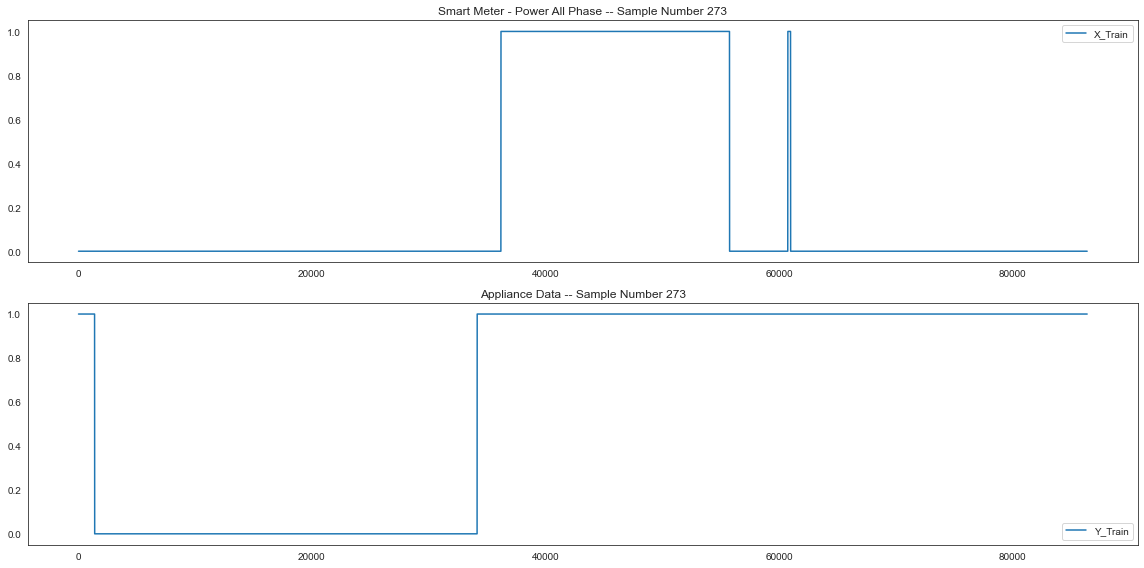

In [15]:
train_data_shape = Y_Train.shape
j = random.randint(0, train_data_shape[0])
A = X_Train[j,:,0]
C = Y_Train[j,:,0]
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.plot(A, label='X_Train')
plt.title(f"Smart Meter - Power All Phase -- Sample Number {j}")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(C, label='Y_Train')
plt.title(f"Appliance Data -- Sample Number {j}")
plt.tight_layout()
plt.legend()

In [12]:
import os
Checkpoint = {}
Checkpoint['X'] = X_Train
Checkpoint['Y'] = Y_Train
RawDataPath = 'Train_Set.pt'
torch.save(Checkpoint, RawDataPath)

In [16]:
import os
Checkpoint = {}
Checkpoint['X'] = X_Val
Checkpoint['Y'] = Y_Val
RawDataPath = 'Val_Set.pt'
torch.save(Checkpoint, RawDataPath)

In [17]:
import os
Checkpoint = {}
Checkpoint['X'] = X_Test
Checkpoint['Y'] = Y_Test
RawDataPath = 'Test_Set.pt'
torch.save(Checkpoint, RawDataPath)

### Garbage Collector

In [ ]:
import gc #Garbage Collector
fl_Data = None
X_Test = None
X_Train = None
X_Val = None
Y_Test = None
Y_Train = None
Y_Val = None
gc.collect()

0

# MAIN

## Configurations

In [8]:
# Configurations
## General Configurations
signal_length = 86400  # Length of each Segment
model_name = 'UNet4P'  # UNet, UNetPP, etc.
model_depth = 4  # Number of Level in the CNN Model
model_width = 64  # Width of the Initial Layer, subsequent layers start from here
kernel_size = 3  # Size of the Kernels/Filter
num_channel = 1 # Number of Channels in the Model
D_S = 1  # Turn on Deep Supervision
A_E = 0  # Turn on AutoEncoder Mode for Feature Extraction
A_G = 0  # Turn on for Guided Attention
LSTM = 0  # Turn on BiConvLSTM Block
problem_type = 'Regression'
output_nums = 1  # Number of Class for Classification Problems, always '1' for Regression Problems
is_transconv = True # True: Transposed Convolution, False: UpSampling
feature_number = 1024  # Number of Features to be Extracted, only required if the AutoEncoder Mode is turned on

## Model Specific Configurations
alpha = 1  # Model Width Expansion Parameter, for MultiResUNet only
# pooling_type = 'mix' # pooling_type, only for EMARS
# cardinality = 5  # Cardinality, only for EMARS
q = 3
t = 1

## Data Configurations
DS_Model_Type = 'UNetPP' # UNet or UNetPP

## Experimental Configurations8
load_weights = False
max_epoch_stop = 30
max_epoch_lr_change = 10
lr = 5e-4
lr_factor = 0.1
monitor_param = 'loss'  # 'loss' or 'acc' for monitoring

# Loss Weight Dictionary for Deep Supervision
if D_S == 1:
    loss_weights = np.zeros(model_depth)
    for k in range(0, model_depth):
        loss_weights[k] = 1-(k*0.1)

## Helper Functions

In [9]:
def prepareTrainDict(y, model_depth, signal_length, model_name, num_channel=1):
    def approximate(inp, w_len, signal_length, num_channel):
        ops = np.zeros((len(inp), signal_length//w_len, num_channel))
        for j in range(0,num_channel):
            op = np.zeros((len(inp), signal_length//w_len))
            for i in range(0, signal_length, w_len):
                try:
                    op[:, i//w_len] = np.mean(inp[:, i:i+w_len, j], axis=1)
                except Exception as e:
                    print(e)
                    print(i)
            ops[:,:,j] = op
        return ops

    out = {}
    Y_Train_dict = {}
    out['out'] = np.array(y)
    Y_Train_dict['out'] = out['out']
    for i in range(1, (model_depth+1)):
        name = f'level{i}'
        if model_name == 'UNet':
            out[name] = approximate(y, 2**i, signal_length, num_channel)
        elif model_name == 'UNetPP':
            out[name] = y
        Y_Train_dict[f'level{i}'] = out[f'level{i}']

    return Y_Train_dict

In [10]:
def Construction_Error(GRND, Pred):
    mae_construction_err = []
    mse_construction_err = []
    rmse_construction_err = []
    cc = []
    r2c = []
    bad_indices = []
    count = 0

    for i in range(len(GRND)):

        MAE = np.mean(np.abs(Pred[i].ravel() - GRND[i].ravel()))
        MSE = mean_squared_error(
            Pred[i].ravel(), GRND[i].ravel(), squared=True)
        RMSE = mean_squared_error(
            Pred[i].ravel(), GRND[i].ravel(), squared=False)

        if ~(np.std(Pred[i].ravel()) == 0 or np.std(GRND[i].ravel()) == 0):
            corr, _ = stats.pearsonr(Pred[i].ravel(), GRND[i].ravel())
            r2_scr = r2_score(Pred[i].ravel(), GRND[i].ravel())
        else:
            continue

        if MAE < 1:
            mae_construction_err.append(MAE)
            mse_construction_err.append(MSE)
            rmse_construction_err.append(RMSE)
            cc.append(corr)
            r2c.append(r2_scr)
        elif MAE >= 1:
            count = count + 1
            bad_indices.append(i)

    print(f'MAE Construction Error: {round(np.mean(mae_construction_err), 3)} +/- {round(np.std(mae_construction_err), 3)}')
    print(f'MSE Construction Error: {round(np.mean(mse_construction_err), 3)} +/- {round(np.std(mse_construction_err), 3)}')
    print(f'RMSE Construction Error: {round(np.mean(rmse_construction_err), 3)} +/- {round(np.std(rmse_construction_err), 3)}')
    print(f'Pearson Correlation: {round(np.mean(cc)*100, 3)}% +/- {round(np.std(cc)*100, 3)}')
    print(f'R-squared (R²) Score: {round(np.mean(r2c)*100, 3)}% +/- {round(np.std(r2c)*100, 3)}')
    print(f'Number of Bad Predictions = {count}')

In [11]:
def Construction_Error_Denorm(GRND, Pred):
    mae_construction_err = []
    mse_construction_err = []
    rmse_construction_err = []
    cc = []
    r2c = []
    count = 0

    for i in range(len(GRND)):

        MAE = np.mean(np.abs(Pred[i].ravel() - GRND[i].ravel()))
        MSE = mean_squared_error(
            Pred[i].ravel(), GRND[i].ravel(), squared=True)
        RMSE = mean_squared_error(
            Pred[i].ravel(), GRND[i].ravel(), squared=False)

        if ~(np.std(Pred[i].ravel()) == 0 or np.std(GRND[i].ravel()) == 0):
            corr, _ = stats.pearsonr(Pred[i].ravel(), GRND[i].ravel())
            r2_scr = r2_score(Pred[i].ravel(), GRND[i].ravel())
        else:
            continue

        mae_construction_err.append(MAE)
        mse_construction_err.append(MSE)
        rmse_construction_err.append(RMSE)
        cc.append(corr)
        r2c.append(r2_scr)

    print(f'MAE Construction Error: {round(np.mean(mae_construction_err), 3)} +/- {round(np.std(mae_construction_err), 3)}')
    print(f'MSE Construction Error: {round(np.mean(mse_construction_err), 3)} +/- {round(np.std(mse_construction_err), 3)}')
    print(f'RMSE Construction Error: {round(np.mean(rmse_construction_err), 3)} +/- {round(np.std(rmse_construction_err), 3)}')
    print(f'Pearson Correlation: {round(np.mean(cc)*100, 3)}% +/- {round(np.std(cc)*100, 3)}')
    print(f'R-squared (R²) Score: {round(np.mean(r2c)*100, 3)}% +/- {round(np.std(r2c)*100, 3)}')

## Train and Test

Build Model for 1D Segmentation

In [22]:
# Build model for PPG2ABP Segmentation - Deep UNet Architecture
SMDisAgg_Network = UNet(signal_length, model_depth, num_channel, model_width, kernel_size, problem_type='Regression', 
                        output_nums=output_nums, ds=D_S, ae=A_E, ag=A_G, lstm=LSTM, alpha=alpha, t=t, 
                        feature_number=feature_number, is_transconv=is_transconv, q=q).UNet4P()
# print(SMDisAgg_Network.summary())

In [ ]:
# Load Data
Train_Data = torch.load('Train_Set.pt')
Test_Data = torch.load('Test_Set.pt')
Val_Data = torch.load('Train_Set.pt')
X_Train = Train_Data['X']
Y_Train = Train_Data['Y']
X_Test = Test_Data['X']
Y_Test = Test_Data['Y']
X_Val = Val_Data['X']
Y_Val = Val_Data['Y']
if D_S == 0:  # Deep Supervision OFF
    # Compile Built Model
    SMDisAgg_Network.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=tf.keras.metrics.MeanSquaredError())
    # Directory for Saving Trained Models
    save_directory = f'trained_models/{model_name}/'+model_name+'_'+str(signal_length)+'_'+str(model_width)+'_'+str(num_channel)+'_'+str(D_S)+'.h5'
    # Load Pretrained Weights (if available)
    if (os.path.exists(save_directory) and load_weights == True):
        print('\nLoading Pretrained Weights...')
        # Load Previously Trained Weights for Transfer Learning
        SMDisAgg_Network.load_weights(save_directory)
    # Declare Callbacks
    if monitor_param == 'loss':
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=max_epoch_stop, mode='min'),
                    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=lr_factor, patience=max_epoch_lr_change, verbose=1, mode='min'),
                    tf.keras.callbacks.ModelCheckpoint(save_directory, verbose=1, monitor='val_loss', save_best_only=True, mode='min')]
    elif monitor_param == 'acc':
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=max_epoch_stop, mode='max'),
                    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=lr_factor, patience=max_epoch_lr_change, verbose=1, mode='max'),
                    tf.keras.callbacks.ModelCheckpoint(save_directory, verbose=1, monitor='val_acc', save_best_only=True, mode='max')]
    # Train Model
    print('Starting Training...')
    model_history = SMDisAgg_Network.fit(X_Train, Y_Train, epochs=500, batch_size=16, verbose=1, validation_data=(X_Val, Y_Val), shuffle=True, callbacks=callbacks)
    # Test and Evaluation
    Y_Pred = SMDisAgg_Network.predict(X_Test, verbose=0)
    # Save History
    print('\n')
    print('Save History')
    # Get the dictionary containing each metric and the loss for each epoch
    history_dict = model_history.history
    history_path = f'Outcomes/{model_name}_{device}_History.h5'
    json.dump(history_dict.item(), open(history_path, 'w'))
    print('\n')
    # Save Outcomes
    print('Save Results')
    File = h5py.File(f'Outcomes/{model_name}_Ch{num_channel}_F{fold}_P{phase}_D{device}.h5', 'w')
    File.create_dataset('SM', data=X_Test)
    File.create_dataset('App', data=Y_Test)
    File.create_dataset('App_Pred', data=Y_Pred)
    File.close()
    print('\n')
elif D_S == 1:  # Deep Supervision ON
    # Prepare Train and Test Sets for Deep Supervision
    Y_Train_dict = prepareTrainDict(Y_Train, model_depth, signal_length, DS_Model_Type)
    Y_Val_dict = prepareTrainDict(Y_Val, model_depth, signal_length, DS_Model_Type)
    # Generate Custom Loss Weights for Deep Supervision
    loss_weights = np.zeros(model_depth)
    for k in range(0, model_depth):
        loss_weights[k] = 1-(k*0.1)
    # Compile Built Model
    SMDisAgg_Network.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=tf.keras.metrics.MeanSquaredError(), loss_weights=loss_weights)
    # Directory for Saving Trained Models
    save_directory = f'trained_models/{model_name}/'+model_name+'_'+str(signal_length)+'_'+str(model_width)+'_'+str(num_channel)+'_'+str(D_S)+'.h5'
    # Load Pretrained Weights (if available)
    if (os.path.exists(save_directory) and load_weights == True):
        print('Loading Pretrained Weights...')
        # Load Previously Trained Weights for Transfer Learning
        SMDisAgg_Network.load_weights(save_directory)
    # Declare Callbacks
    if monitor_param == 'loss':
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_out_loss', patience=max_epoch_stop, mode='min'),
                    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_out_loss', factor=lr_factor, patience=max_epoch_lr_change, verbose=1, mode='min'),
                    tf.keras.callbacks.ModelCheckpoint(save_directory, verbose=1, monitor='val_out_loss', save_best_only=True, mode='min')]
    elif monitor_param == 'acc':
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_out_acc', patience=max_epoch_stop, mode='max'),
                    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_out_acc', factor=lr_factor, patience=max_epoch_lr_change, verbose=1, mode='max'),
                    tf.keras.callbacks.ModelCheckpoint(save_directory, verbose=1, monitor='val_out_acc', save_best_only=True, mode='max')]
    # Train Model
    print('Starting Training...')
    model_history = SMDisAgg_Network.fit(X_Train, Y_Train_dict, epochs=500, batch_size=1, verbose=1, validation_data=(X_Val, Y_Val_dict), shuffle=True, callbacks=callbacks)
    # Test and Evaluation
    Y_Pred = SMDisAgg_Network.predict(X_Test, verbose=0)
    Y_Pred = Y_Pred[0]
    '''Test and Evaluation'''
    # Save History
    print('\n')
    print('Save History')
    # Get the dictionary containing each metric and the loss for each epoch
    history_dict = model_history.history
    history_path = f'History/{model_name}_{device}_History.h5'
    with open(history_path, 'wb') as file:
        history_dict = model_history.history
        pickle.dump(history_dict, file, pickle.HIGHEST_PROTOCOL)
    print('\n')
    # Save Outcomes
    print('Save Results')
    File = h5py.File(f'Outcomes/{model_name}_Ch{num_channel}_F{fold}_P{phase}_{device}.h5', 'w')
    File.create_dataset('SM', data=X_Test)
    File.create_dataset('App', data=Y_Test)
    File.create_dataset('App_Pred', data=Y_Pred)
    File.close()
    print('\n')

In [ ]:
# Save History
print('\n')
print('Save History')
# Get the dictionary containing each metric and the loss for each epoch
history_dict = model_history.history
history_path = f'History/{model_name}_{device}_History.h5'
with open(history_path, 'wb') as file:
    history_dict = model_history.history
    pickle.dump(history_dict, file, pickle.HIGHEST_PROTOCOL)
print('\n')

Load History

In [ ]:
with open(history_path, 'rb') as file:
    history=pickle.load(file)
print(history.keys())

External Evaluation

In [29]:
SMDisAgg_Network = UNet(signal_length, model_depth, num_channel, model_width, kernel_size, problem_type=problem_type, output_nums=output_nums, 
                      ds=D_S, ae=A_E, ag=A_G, t=t, is_transconv=is_transconv, q=q).UNet4P()
if D_S == 0:
    SMDisAgg_Network.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=tf.keras.metrics.MeanSquaredError())
elif D_S == 1:
    SMDisAgg_Network.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=tf.keras.metrics.MeanSquaredError(), loss_weights= loss_weights)

In [30]:
# Load Model and Predict
save_directory = f'trained_models/{model_name}/'+model_name+'_'+str(signal_length)+'_'+str(model_width)+'_'+str(num_channel)+'_'+str(D_S)+'.h5'
SMDisAgg_Network.load_weights(save_directory)
# Load Test Set
Test_Data = torch.load('Test_Set.pt')
X_Test = Test_Data['X']
Y_Test = Test_Data['Y']
print(X_Test.shape)
print(Y_Test.shape)
# Predict
Y_Pred = SMDisAgg_Network.predict(X_Test, verbose=0)
Y_Pred = Y_Pred[0]
print(Y_Pred.shape)

(38, 21600, 1)
(38, 21600, 1)
(38, 21600, 1)


In [16]:
# Save Outcomes
print('Save Results')
File = h5py.File(f'Outcomes/{model_name}_Ch{num_channel}_F{fold}_P{phase}.h5', 'w')
File.create_dataset('SM', data=X_Test)
File.create_dataset('App', data=Y_Test)
File.create_dataset('App_Pred', data=Y_Pred)
File.close()
print('\n')

Save Results




In [ ]:
# Load Resuts with Ground Truth and Inputs
fl_Data = h5py.File(os.path.join('Outcomes/UNet_4_64_DS_Microwave_SM3_21600.h5'),'r')
print(fl_Data.keys())
X_Test = fl_Data['SM']
Y_Test = fl_Data['App']
Y_Pred = fl_Data['App_Pred']
# Y_Test_Denorm = fl_Data['App_Denorm']
# Y_Pred_Denorm = fl_Data['App_Pred_Denorm']

In [11]:
# Load Test Set and Print Shape
Test_Data = torch.load('Test_Set.pt')
X_Test = Test_Data['X']
Y_Test = Test_Data['Y']
print(X_Test.shape)
print(Y_Test.shape)
# Load Resuts
fl_Data = h5py.File(os.path.join('Outcomes/UNet4P_Ch1_F1_P2_Air_Exhaust.h5'), 'r')
print(fl_Data.keys())
Y_Pred = np.array(fl_Data['App_Pred'])
# Y_Pred[Y_Pred >= 0.5] = 1
# Y_Pred[Y_Pred < 0.5] = 0

(38, 21600, 1)
(38, 21600, 1)
<KeysViewHDF5 ['App', 'App_Pred', 'SM']>


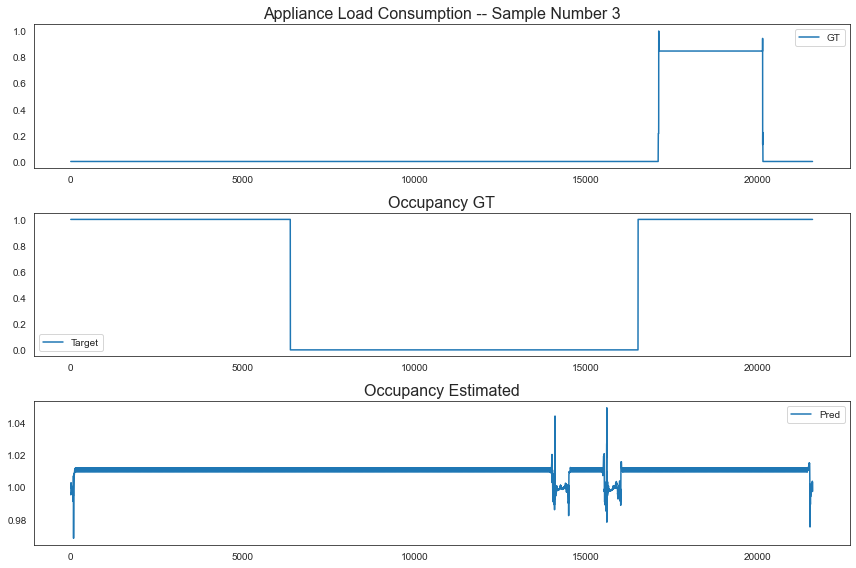

In [13]:
# Plot
data_shape = X_Test.shape
i = random.randint(0, data_shape[0])
plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.plot(X_Test[i,:,0], label='GT')
# plt.ylim(0,1)
plt.title(f"Appliance Load Consumption -- Sample Number {i}", fontdict={'fontsize': 16})
plt.legend()
plt.subplot(3,1,2)
plt.plot(Y_Test[i,:,0], label='Target')
# plt.ylim(0,1)
plt.title(f"Occupancy GT", fontdict={'fontsize': 16})
plt.legend()
plt.subplot(3,1,3)
plt.plot(Y_Pred[i,:,0], label='Pred')
# plt.ylim(0,1)
plt.title(f"Occupancy Estimated", fontdict={'fontsize': 16})
plt.legend()
plt.tight_layout()

In [ ]:
Construction_Error(Y_Test, Y_Pred)

In [18]:
# Save Outcomes
print('Saving Results')
File = h5py.File(f'Outcomes/UNet4P_5_32_DS_Microwave_SM3_21600_Overlapped.h5', 'w')
File.create_dataset('SM', data=X_Test)
File.create_dataset('App', data=Y_Test)
File.create_dataset('App_Pred', data=Y_Pred)
File.create_dataset('App_Denorm', data=Y_Test_Denorm)
File.create_dataset('App_Pred_Denorm', data=Y_Pred_Denorm)
File.close()

Saving Results


In [ ]:
# Load Resuts
fl_Data = h5py.File(os.path.join('Outcomes/UNet4P_5_32_DS_Microwave_SM3_21600_Overlapped.h5'), 'r')
print(fl_Data.keys())
X_Test = fl_Data['SM']
Y_Test = fl_Data['App']
Y_Pred = fl_Data['App_Pred']
Y_Test_Denorm = fl_Data['App_Denorm']
Y_Pred_Denorm = fl_Data['App_Pred_Denorm']

# Plots for article

In [7]:
def Calculate_JEOI(GRND, Pred):
    JEOI = []
    for i in range(0,len(GRND)):
        GRND_Temp = GRND[i].ravel()
        Pred_Temp = Pred[i].ravel()
        EO_Temp_TOT = 0
        EE_Temp_TOT = 0
        EM_Temp_TOT = 0
        for ii in range(len(GRND_Temp)):
            if Pred_Temp[ii] < 0:
                Pred_Temp[ii] = 0
            if GRND_Temp[ii] > Pred_Temp[ii]:
                EO_Temp = Pred_Temp[ii]
                EE_Temp = 0
                EM_Temp = np.abs(GRND_Temp[ii] - Pred_Temp[ii])
            elif GRND_Temp[ii] < Pred_Temp[ii]:
                EO_Temp = GRND_Temp[ii]
                EE_Temp = np.abs(Pred_Temp[ii] - GRND_Temp[ii])
                EM_Temp = 0
            elif GRND_Temp[ii] == Pred_Temp[ii]:
                EO_Temp = GRND_Temp[ii]
                EE_Temp = 0
                EM_Temp = 0
            # EO_Temp = min(GRND_Temp[ii], Pred_Temp[ii])
            # EE_Temp = max(GRND_Temp[ii], Pred_Temp[ii])
            EO_Temp_TOT = EO_Temp_TOT + EO_Temp
            EE_Temp_TOT = EE_Temp_TOT + EE_Temp
            EM_Temp_TOT = EM_Temp_TOT + EM_Temp
        # EO_Temp_Norm = EO_Temp_TOT/EG_Temp_TOT
        # EE_Temp_Norm = EE_Temp_TOT/EG_Temp_TOT
        # EM_Temp_Norm = EM_Temp_TOT/EG_Temp_TOT
        JEOI_Temp = EO_Temp_TOT/(EO_Temp_TOT+EE_Temp_TOT+EM_Temp_TOT)
        JEOI.append(JEOI_Temp)
    JEOI_OVR = round(np.mean(JEOI), 5)
    return JEOI_OVR

In [8]:
def Calculate_DEOI(GRND, Pred):
    DEOI = []
    for i in range(0,len(GRND)):
        GRND_Temp = GRND[i].ravel()
        Pred_Temp = Pred[i].ravel()
        EO_Temp_TOT = 0
        EE_Temp_TOT = 0
        EM_Temp_TOT = 0
        for ii in range(len(GRND_Temp)):
            if Pred_Temp[ii] < 0:
                Pred_Temp[ii] = 0
            if GRND_Temp[ii] > Pred_Temp[ii]:
                EO_Temp = Pred_Temp[ii]
                EE_Temp = 0
                EM_Temp = np.abs(GRND_Temp[ii] - Pred_Temp[ii])
            elif GRND_Temp[ii] < Pred_Temp[ii]:
                EO_Temp = GRND_Temp[ii]
                EE_Temp = np.abs(Pred_Temp[ii] - GRND_Temp[ii])
                EM_Temp = 0
            elif GRND_Temp[ii] == Pred_Temp[ii]:
                EO_Temp = GRND_Temp[ii]
                EE_Temp = 0
                EM_Temp = 0
            # EO_Temp = min(GRND_Temp[ii], Pred_Temp[ii])
            # EE_Temp = max(GRND_Temp[ii], Pred_Temp[ii])
            EO_Temp_TOT = EO_Temp_TOT + EO_Temp
            EE_Temp_TOT = EE_Temp_TOT + EE_Temp
            EM_Temp_TOT = EM_Temp_TOT + EM_Temp
        # EO_Temp_Norm = EO_Temp_TOT/EG_Temp_TOT
        # EE_Temp_Norm = EE_Temp_TOT/EG_Temp_TOT
        # EM_Temp_Norm = EM_Temp_TOT/EG_Temp_TOT
        DEOI_Temp = (2*EO_Temp_TOT)/((2*EO_Temp_TOT)+EE_Temp_TOT+EM_Temp_TOT)
        DEOI.append(DEOI_Temp)
    DEOI_OVR = round(np.mean(DEOI), 5)
    return DEOI_OVR

In [13]:
def Evaluation_Metrics(Grnd, Pred):
    print(Grnd.shape)
    print(Pred.shape)
    mae_err = []
    mse_err = []
    rmse_err = []
    pcc = []
    r2c = []
    cs = []
    dsc_ = []
    iou_ = []
    for i in range(0,len(Grnd)):
        grnd_temp = Grnd[i:i+1,:,:]
        pred_temp = Pred[i:i+1,:,:]
        grnd_current_sample_norm = grnd_temp.ravel()
        pred_current_sample_norm = pred_temp.ravel()
        DSC = Calculate_DEOI(grnd_temp, pred_temp)
        IOU = Calculate_JEOI(grnd_temp, pred_temp)
        MAE = np.mean(np.abs(pred_current_sample_norm - grnd_current_sample_norm))
        MSE = mean_squared_error(pred_current_sample_norm, grnd_current_sample_norm)
        RMSE = root_mean_squared_error(pred_current_sample_norm, grnd_current_sample_norm)
        if ~(np.std(grnd_current_sample_norm) == 0 or np.std(pred_current_sample_norm) == 0):
            pcorr, _ = stats.pearsonr(pred_current_sample_norm, grnd_current_sample_norm)
            r2_scr = r2_score(pred_current_sample_norm, grnd_current_sample_norm)
            cs_scr = np.dot(pred_current_sample_norm,grnd_current_sample_norm)/(np.linalg.norm(pred_current_sample_norm)*np.linalg.norm(grnd_current_sample_norm))
        else:
            continue
        mae_err.append(MAE)
        mse_err.append(MSE)
        rmse_err.append(RMSE)
        pcc.append(pcorr)
        r2c.append(r2_scr)
        cs.append(cs_scr)
        dsc_.append(DSC)
        iou_.append(IOU)
    print(f'MAE Error: {round(np.mean(mae_err), 3)} +/- {round(np.std(mae_err), 3)}')
    print(f'MSE Error: {round(np.mean(mse_err), 3)} +/- {round(np.std(mse_err), 3)}')
    print(f'RMSE Error: {round(np.mean(rmse_err), 3)} +/- {round(np.std(rmse_err), 3)}')
    print(f'R-squared (R²) Score: {round(np.mean(r2c)*100, 3)}% +/- {round(np.std(r2c)*100, 3)}')
    print(f'Pearson Correlation (PCC): {round(np.mean(pcc)*100, 3)}% +/- {round(np.std(pcc)*100, 3)}')
    print(f'Cosine Similarity: {round(np.mean(cs)*100, 3)}% +/- {round(np.std(cs)*100, 3)}')
    print(f'DSC or Dice Score: {round(np.mean(dsc_)*100, 4)}% +/- {round(np.std(dsc_)*100, 3)}')
    print(f'IoU or Jaccard Score: {round(np.mean(iou_)*100, 4)}% +/- {round(np.std(iou_)*100, 3)}')
    
    return round(np.mean(mae_err), 3), round(np.mean(mse_err), 3), round(np.mean(rmse_err), 3), round(np.mean(r2c)*100, 3), round(np.mean(pcc)*100, 3), round(np.mean(cs)*100, 3), round(np.mean(dsc_)*100, 4), round(np.mean(iou_)*100, 4)

## Load Results

### Load Dishwasher Data

In [409]:
# Load Resuts
fl_Data = h5py.File(os.path.join('Outcomes/Phase_1/LDNet/LDNet_5_32_DS_Dishwasher_SM3_21600_Overlapped.h5'),'r')
print(fl_Data.keys())
X_Test = fl_Data['SM']
Y_Test = fl_Data['App']
Y_Pred = fl_Data['App_Pred']
Y_Test_Denorm = fl_Data['App_Denorm']
Y_Pred_Denorm = fl_Data['App_Pred_Denorm']
#
X_Test_Dishwasher = X_Test[8,:,1]*4500
Y_Test_Dishwasher = Y_Test_Denorm[8,:,0]
Y_Pred_Dishwasher = Y_Pred_Denorm[8,:,0]

<KeysViewHDF5 ['App', 'App_Denorm', 'App_Pred', 'App_Pred_Denorm', 'SM']>


In [ ]:
# Plot
data_shape = X_Test.shape
i = i+1
# i = 0
print(i)
fig, ax = plt.subplots(figsize=(8,2), dpi=300, layout='constrained', facecolor='white')
# Subplot 1 Data
Y_Test_Temp = np.expand_dims(np.expand_dims(Y_Test_Denorm[i,:,0], axis=0), axis=2)
Y_Pred_Temp = np.expand_dims(np.expand_dims(Y_Pred_Denorm[i,:,0], axis=0), axis=2)
t_ = np.arange(0, len(Y_Test_Temp.ravel()))*4
print(Y_Test_Temp.shape)
MAE, MSE, RMSE, R2C, PCC, CS, DEOI, JEOI = Evaluation_Metrics(Y_Test_Temp, Y_Pred_Temp)
#
ax.plot(t_, Y_Test_Temp.ravel(), label='GT', color='navy')
ax.plot(t_, Y_Pred_Temp.ravel(), label='Pred (alpha=0.5)', color='#a50026', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks(fontsize=14)
plt.xticks([])
plt.title(f"Fridge Load Sample - PCC: {PCC} - DEOI: {DEOI}", fontdict={'fontsize': 16})
# plt.legend()
plt.tight_layout()

### Load Air Exhaust Data

In [425]:
# Load Resuts
fl_Data = h5py.File(os.path.join('Outcomes/Phase_1/LDNet/LDNet_5_32_DS_Air_Exhaust_SM3_21600_Overlapped.h5'), 'r')
print(fl_Data.keys())
X_Test = fl_Data['SM']
Y_Test = fl_Data['App']
Y_Pred = fl_Data['App_Pred']
Y_Test_Denorm = fl_Data['App_Denorm']
Y_Pred_Denorm = fl_Data['App_Pred_Denorm']
#
X_Test_Air_Exhaust = X_Test[7,:,1]*500
Y_Test_Air_Exhaust = Y_Test_Denorm[7,:,0]
Y_Pred_Air_Exhaust = Y_Pred_Denorm[7,:,0]

<KeysViewHDF5 ['App', 'App_Denorm', 'App_Pred', 'App_Pred_Denorm', 'SM']>


14
(1, 21600, 1)
(1, 21600, 1)
(1, 21600, 1)


MAE Error: 0.757 +/- 0.0
MSE Error: 51.296 +/- 0.0
RMSE Error: 7.162 +/- 0.0
R-squared (R²) Score: 43.43% +/- 0.0
Pearson Correlation (PCC): 90.082% +/- 0.0
Cosine Similarity: 90.172% +/- 0.0
DSC or Dice Score: 70.388% +/- 0.0
IoU or Jaccard Score: 54.307% +/- 0.0


/tmp/ipykernel_39662/534989277.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


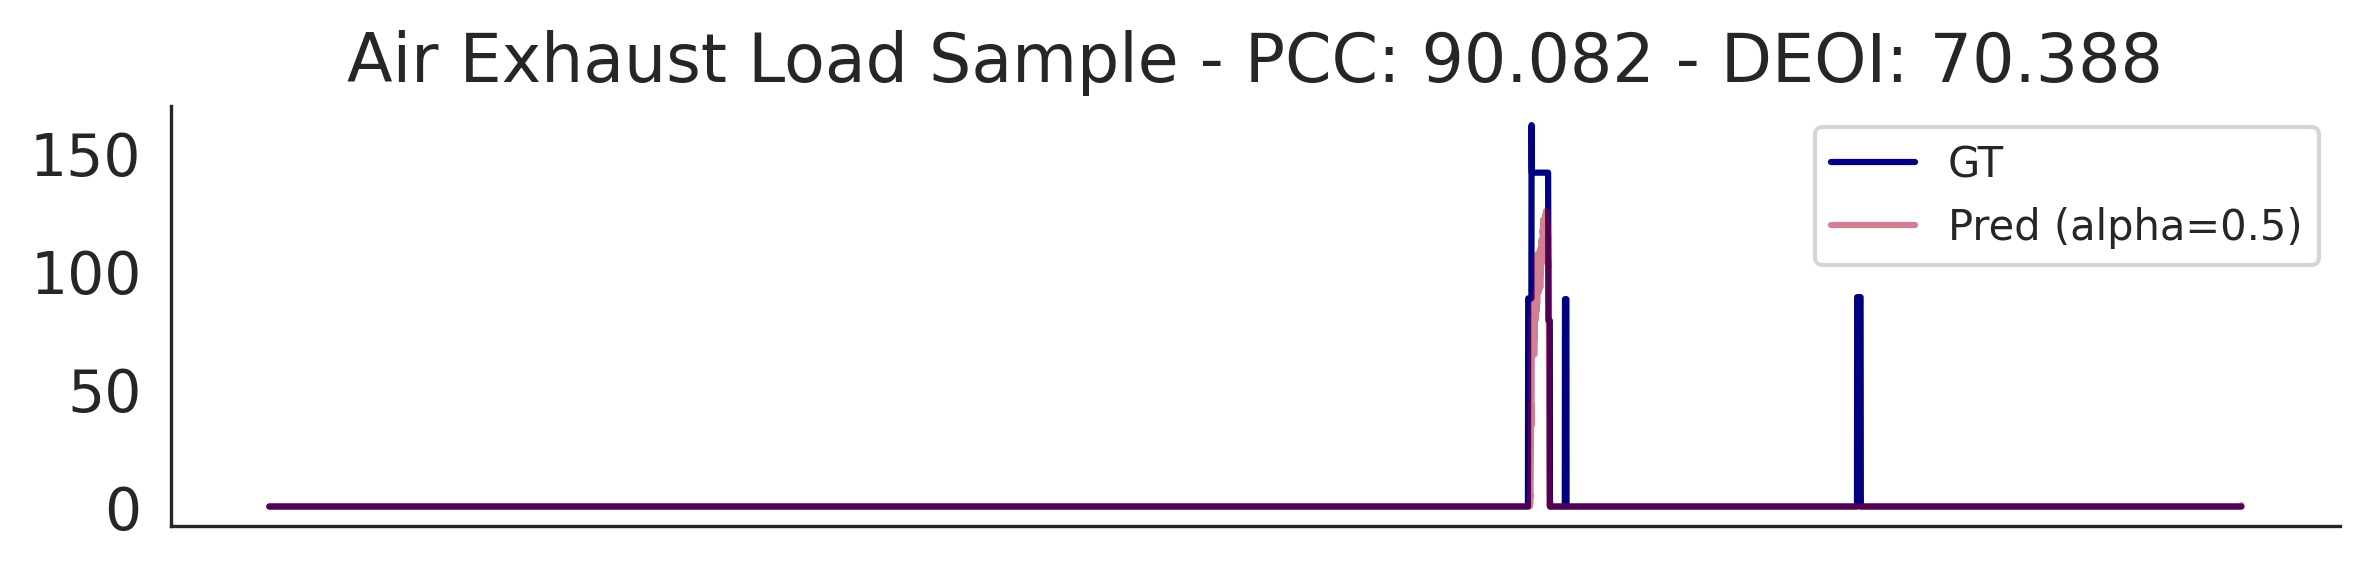

In [427]:
# Plot
data_shape = X_Test.shape
i = random.randint(0, data_shape[0])
i = 14
print(i)
fig, ax = plt.subplots(figsize=(8,2), dpi=300, layout='constrained', facecolor='white')
# Subplot 1 Data
Y_Test_Temp = np.expand_dims(np.expand_dims(Y_Test_Denorm[i,:,0], axis=0), axis=2)
Y_Pred_Temp = np.expand_dims(np.expand_dims(Y_Pred_Denorm[i,:,0], axis=0), axis=2)
t_ = np.arange(0, len(Y_Test_Temp.ravel()))*4
print(Y_Test_Temp.shape)
MAE, MSE, RMSE, R2C, PCC, CS, DEOI, JEOI = Evaluation_Metrics(Y_Test_Temp, Y_Pred_Temp)
#
ax.plot(t_, Y_Test_Temp.ravel(), label='GT', color='navy')
ax.plot(t_, Y_Pred_Temp.ravel(), label='Pred (alpha=0.5)', color='#a50026', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks(fontsize=14)
plt.xticks([])
plt.title(f"Air Exhaust Load Sample - PCC: {PCC} - DEOI: {DEOI}", fontdict={'fontsize': 16})
plt.legend()
plt.tight_layout()

### Load Fridge Data

In [286]:
# Load Resuts
fl_Data = h5py.File(os.path.join('Outcomes/Phase_1/DAGG_Net/UNet4P_5_32_DS_Fridge_SM3_21600_Overlapped.h5'), 'r')
print(fl_Data.keys())
X_Test = fl_Data['SM']
Y_Test = fl_Data['App']
Y_Pred = fl_Data['App_Pred']
Y_Test_Denorm = fl_Data['App_Denorm']
Y_Pred_Denorm = fl_Data['App_Pred_Denorm']
#
X_Test_Fridge = X_Test[4,:,1]*5500
Y_Test_Fridge = Y_Test_Denorm[4,:,0]
Y_Pred_Fridge = Y_Pred_Denorm[4,:,0]

<KeysViewHDF5 ['App', 'App_Denorm', 'App_Pred', 'App_Pred_Denorm', 'SM']>


49
(1, 21600, 1)
(1, 21600, 1)
(1, 21600, 1)
MAE Error: 11.436 +/- 0.0
MSE Error: 318.382 +/- 0.0
RMSE Error: 17.843 +/- 0.0
R-squared (R²) Score: 89.467% +/- 0.0
Pearson Correlation (PCC): 96.278% +/- 0.0
Cosine Similarity: 96.31% +/- 0.0
DSC or Dice Score: 85.757% +/- 0.0
IoU or Jaccard Score: 75.066% +/- 0.0


/tmp/ipykernel_39662/1413785737.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


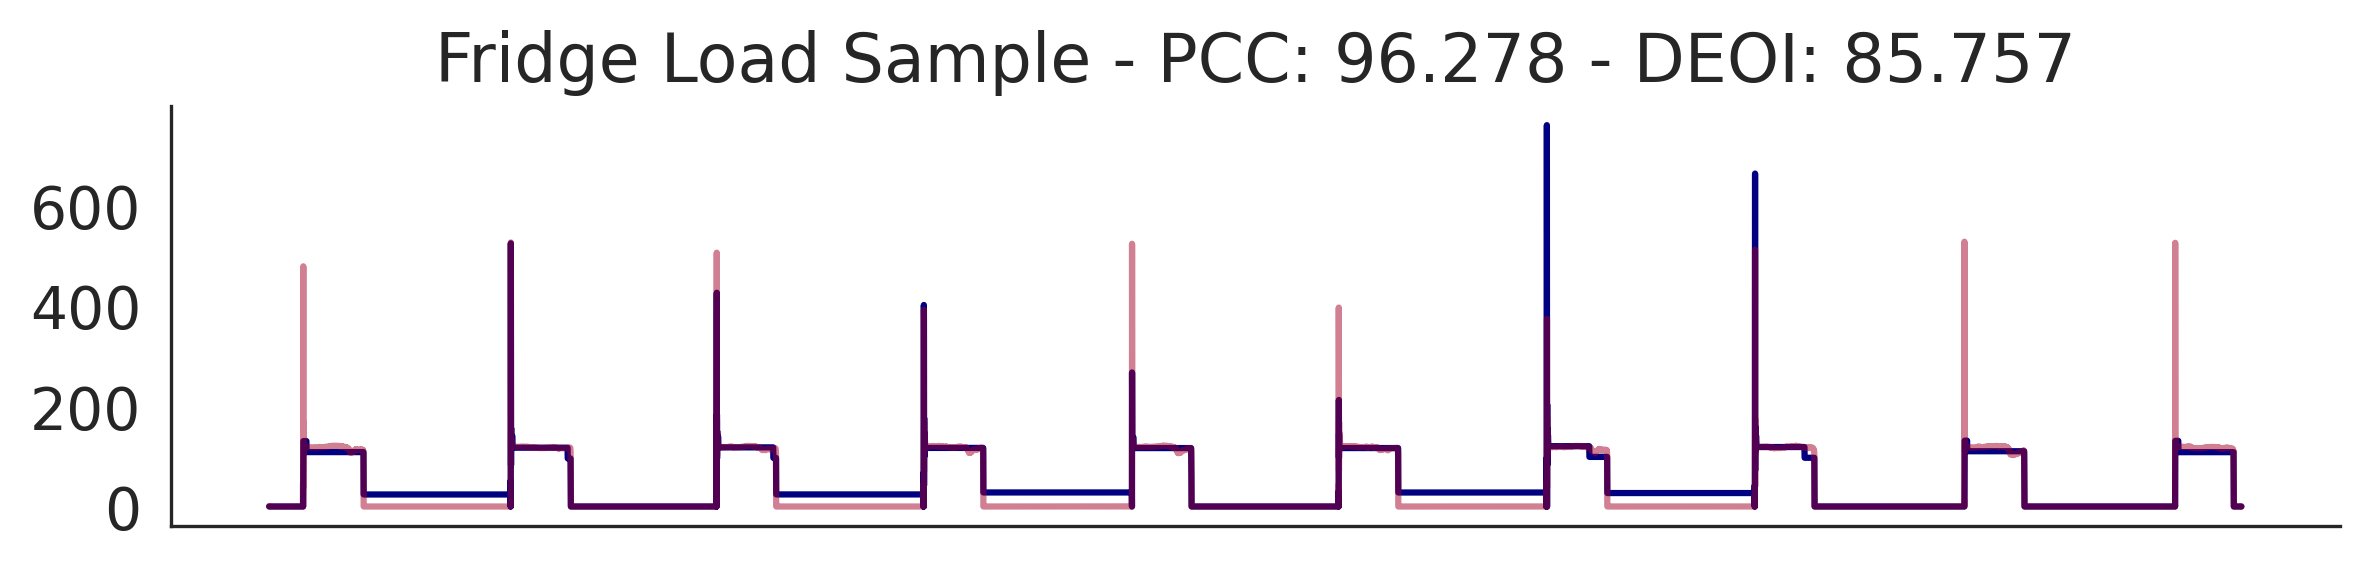

In [407]:
# Plot
data_shape = X_Test.shape
i = 49
# i = 0
print(i)
fig, ax = plt.subplots(figsize=(8,2), dpi=300, layout='constrained', facecolor='white')
# Subplot 1 Data
Y_Test_Temp = np.expand_dims(np.expand_dims(Y_Test_Denorm[i,:,0], axis=0), axis=2)
Y_Pred_Temp = np.expand_dims(np.expand_dims(Y_Pred_Denorm[i,:,0], axis=0), axis=2)
t_ = np.arange(0, len(Y_Test_Temp.ravel()))*4
print(Y_Test_Temp.shape)
MAE, MSE, RMSE, R2C, PCC, CS, DEOI, JEOI = Evaluation_Metrics(Y_Test_Temp, Y_Pred_Temp)
#
ax.plot(t_, Y_Test_Temp.ravel(), label='GT', color='navy')
ax.plot(t_, Y_Pred_Temp.ravel(), label='Pred (alpha=0.5)', color='#a50026', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks(fontsize=14)
plt.xticks([])
plt.title(f"Fridge Load Sample - PCC: {PCC} - DEOI: {DEOI}", fontdict={'fontsize': 16})
# plt.legend()
plt.tight_layout()

### Load Entertainment Data

In [281]:
# Load Resuts
fl_Data = h5py.File(os.path.join('Outcomes/Phase_1/DAGG_Net/UNet4P_5_32_DS_Entertainment_SM3_21600_Overlapped.h5'), 'r')
print(fl_Data.keys())
X_Test = fl_Data['SM']
Y_Test = fl_Data['App']
Y_Pred = fl_Data['App_Pred']
Y_Test_Denorm = fl_Data['App_Denorm']
Y_Pred_Denorm = fl_Data['App_Pred_Denorm']
#
X_Test_Entertainment = X_Test[76,:,1]*1000
Y_Test_Entertainment = Y_Test_Denorm[76,:,0]
Y_Pred_Entertainment = Y_Pred_Denorm[76,:,0]

<KeysViewHDF5 ['App', 'App_Denorm', 'App_Pred', 'App_Pred_Denorm', 'SM']>


46
(1, 21600, 1)
(1, 21600, 1)
(1, 21600, 1)
MAE Error: 4.152 +/- 0.0
MSE Error: 78.532 +/- 0.0
RMSE Error: 8.862 +/- 0.0
R-squared (R²) Score: 93.366% +/- 0.0
Pearson Correlation (PCC): 97.061% +/- 0.0
Cosine Similarity: 96.92% +/- 0.0
DSC or Dice Score: 81.0% +/- 0.0
IoU or Jaccard Score: 68.067% +/- 0.0


/tmp/ipykernel_39662/3569044385.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


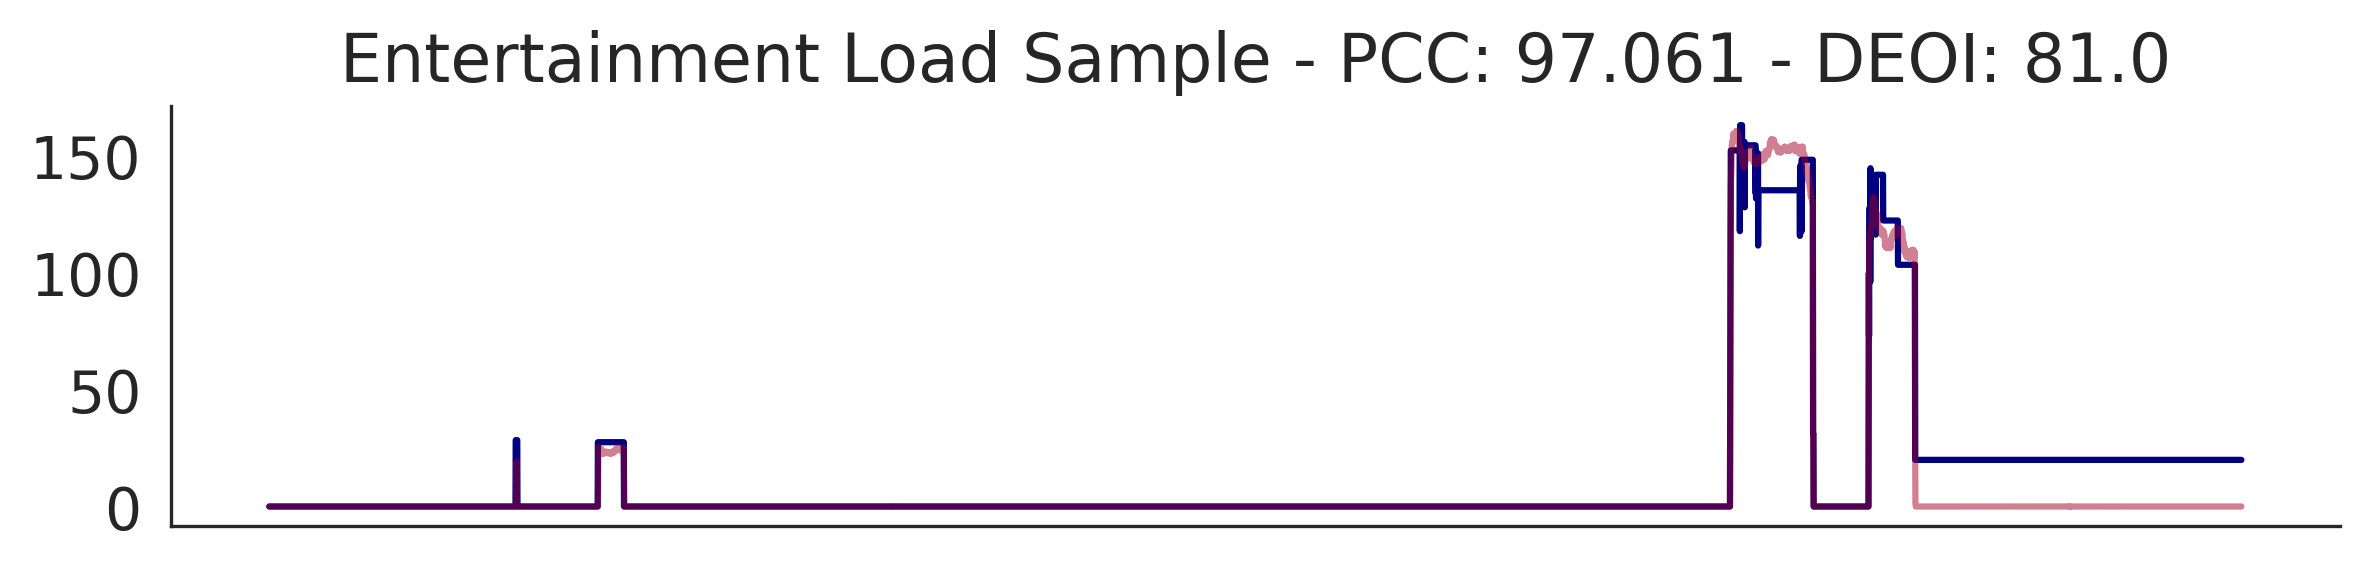

In [285]:
# Plot
data_shape = X_Test.shape
i = random.randint(0, data_shape[0])
i = 46
# i = 0
print(i)
fig, ax = plt.subplots(figsize=(8,2), dpi=300, layout='constrained', facecolor='white')
# Subplot 1 Data
Y_Test_Temp = np.expand_dims(np.expand_dims(Y_Test_Denorm[i,:,0], axis=0), axis=2)
Y_Pred_Temp = np.expand_dims(np.expand_dims(Y_Pred_Denorm[i,:,0], axis=0), axis=2)
t_ = np.arange(0, len(Y_Test_Temp.ravel()))*4
print(Y_Test_Temp.shape)
MAE, MSE, RMSE, R2C, PCC, CS, DEOI, JEOI = Evaluation_Metrics(Y_Test_Temp, Y_Pred_Temp)
#
ax.plot(t_, Y_Test_Temp.ravel(), label='GT', color='navy')
ax.plot(t_, Y_Pred_Temp.ravel(), label='Pred', color='#a50026', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks(fontsize=14)
plt.xticks([])
plt.title(f"Entertainment Load Sample - PCC: {PCC} - DEOI: {DEOI}", fontdict={'fontsize': 16})
# plt.legend()
plt.tight_layout()

### Load Freezer Data

In [16]:
fl_Data = h5py.File(os.path.join('Outcomes/Phase_1/DAGG_Net/UNet4P_5_32_DS_Freezer_SM3_21600_Overlapped.h5'), 'r')
print(fl_Data.keys())
X_Test = fl_Data['SM']
Y_Test = fl_Data['App']
Y_Pred = fl_Data['App_Pred']
Y_Test_Denorm = fl_Data['App_Denorm']
Y_Pred_Denorm = fl_Data['App_Pred_Denorm']
#
X_Test_Freezer = X_Test[21,:,1]*1000
Y_Test_Freezer = Y_Test_Denorm[21,:,0]
Y_Pred_Freezer = Y_Pred_Denorm[21,:,0]

<KeysViewHDF5 ['App', 'App_Denorm', 'App_Pred', 'App_Pred_Denorm', 'SM']>


### Load Kettle Data

In [274]:
fl_Data = h5py.File(os.path.join('Outcomes/Phase_1/DAGG_Net/UNet4P_5_32_DS_Kettle_SM3_21600_Overlapped.h5'), 'r')
print(fl_Data.keys())
X_Test = fl_Data['SM']
Y_Test = fl_Data['App']
Y_Pred = fl_Data['App_Pred']
Y_Test_Denorm = fl_Data['App_Denorm']
Y_Pred_Denorm = fl_Data['App_Pred_Denorm']
#
X_Test_Kettle = X_Test[63,:,1]*5000
Y_Test_Kettle = Y_Test_Denorm[63,:,0]
Y_Pred_Kettle = Y_Pred_Denorm[63,:,0]

<KeysViewHDF5 ['App', 'App_Denorm', 'App_Pred', 'App_Pred_Denorm', 'SM']>


51
(1, 21600, 1)
(1, 21600, 1)
(1, 21600, 1)
MAE Error: 2.525 +/- 0.0
MSE Error: 2836.461 +/- 0.0
RMSE Error: 53.258 +/- 0.0
R-squared (R²) Score: 87.223% +/- 0.0
Pearson Correlation (PCC): 93.406% +/- 0.0
Cosine Similarity: 93.449% +/- 0.0
DSC or Dice Score: 89.654% +/- 0.0
IoU or Jaccard Score: 81.248% +/- 0.0


/tmp/ipykernel_39662/969110252.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


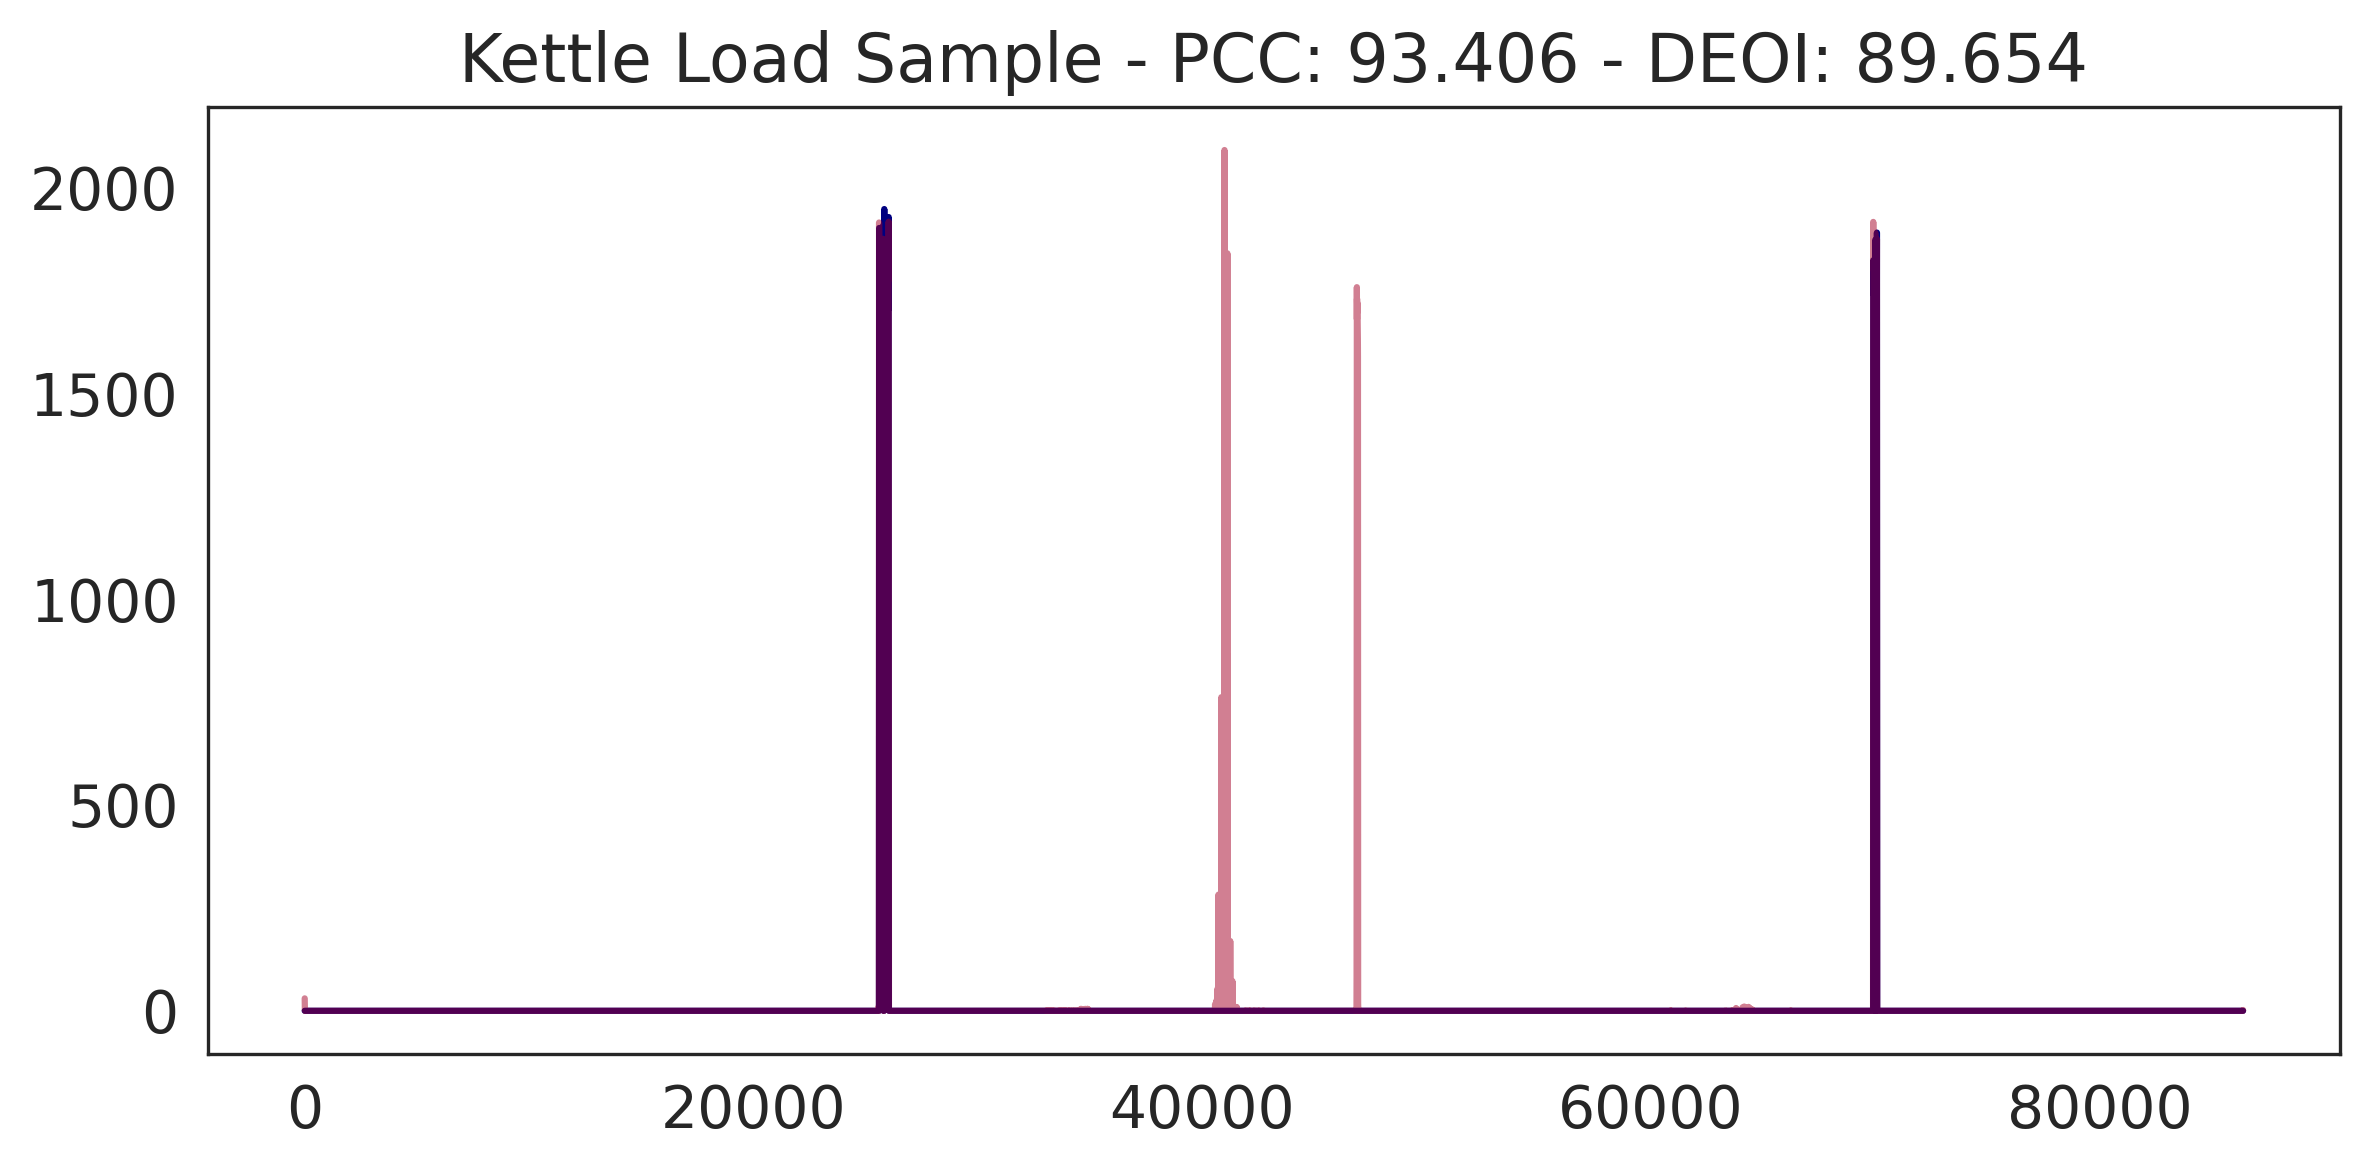

In [275]:
# Plot
data_shape = X_Test.shape
i = random.randint(0, data_shape[0])
i = 51
print(i)
fig, ax = plt.subplots(figsize=(8,4), dpi=300, layout='constrained', facecolor='white')
# Subplot 1 Data
Y_Test_Temp = np.expand_dims(np.expand_dims(Y_Test_Denorm[i,:,0], axis=0), axis=2)
Y_Pred_Temp = np.expand_dims(np.expand_dims(Y_Pred_Denorm[i,:,0], axis=0), axis=2)
t_ = np.arange(0, len(Y_Test_Temp.ravel()))*4
print(Y_Test_Temp.shape)
MAE, MSE, RMSE, R2C, PCC, CS, DEOI, JEOI = Evaluation_Metrics(Y_Test_Temp, Y_Pred_Temp)
#
ax.plot(t_, Y_Test_Temp.ravel(), label='GT', color='navy')
ax.plot(t_, Y_Pred_Temp.ravel(), label='Pred', color='#a50026', alpha=0.5)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title(f"Kettle Load Sample - PCC: {PCC} - DEOI: {DEOI}", fontdict={'fontsize': 16})
# plt.legend()
plt.tight_layout()

### Load Lamp Data

In [18]:
fl_Data = h5py.File(os.path.join('Outcomes/Phase_1/DAGG_Net/UNet4P_5_32_DS_Lamp_SM3_21600_Overlapped.h5'), 'r')
print(fl_Data.keys())
X_Test = fl_Data['SM']
Y_Test = fl_Data['App']
Y_Pred = fl_Data['App_Pred']
Y_Test_Denorm = fl_Data['App_Denorm']
Y_Pred_Denorm = fl_Data['App_Pred_Denorm']
#
X_Test_Lamp = X_Test[19,:,1]*2500
Y_Test_Lamp = Y_Test_Denorm[19,:,0]
Y_Pred_Lamp = Y_Pred_Denorm[19,:,0]

<KeysViewHDF5 ['App', 'App_Denorm', 'App_Pred', 'App_Pred_Denorm', 'SM']>


### Load Laptop Data

In [276]:
fl_Data = h5py.File(os.path.join('Outcomes/Phase_1/DAGG_Net/UNet4P_5_32_DS_Laptop_SM3_21600_Overlapped.h5'), 'r')
print(fl_Data.keys())
X_Test = fl_Data['SM']
Y_Test = fl_Data['App']
Y_Pred = fl_Data['App_Pred']
Y_Test_Denorm = fl_Data['App_Denorm']
Y_Pred_Denorm = fl_Data['App_Pred_Denorm']
#
X_Test_Laptop = X_Test[25,:,1]*2500
Y_Test_Laptop = Y_Test_Denorm[25,:,0]
Y_Pred_Laptop = Y_Pred_Denorm[25,:,0]

<KeysViewHDF5 ['App', 'App_Denorm', 'App_Pred', 'App_Pred_Denorm', 'SM']>


1
(1, 21600, 1)
(1, 21600, 1)
(1, 21600, 1)
MAE Error: 1.661 +/- 0.0
MSE Error: 19.68 +/- 0.0
RMSE Error: 4.436 +/- 0.0
R-squared (R²) Score: 98.553% +/- 0.0
Pearson Correlation (PCC): 99.293% +/- 0.0
Cosine Similarity: 99.464% +/- 0.0
DSC or Dice Score: 96.154% +/- 0.0
IoU or Jaccard Score: 92.593% +/- 0.0


/tmp/ipykernel_39662/7590751.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


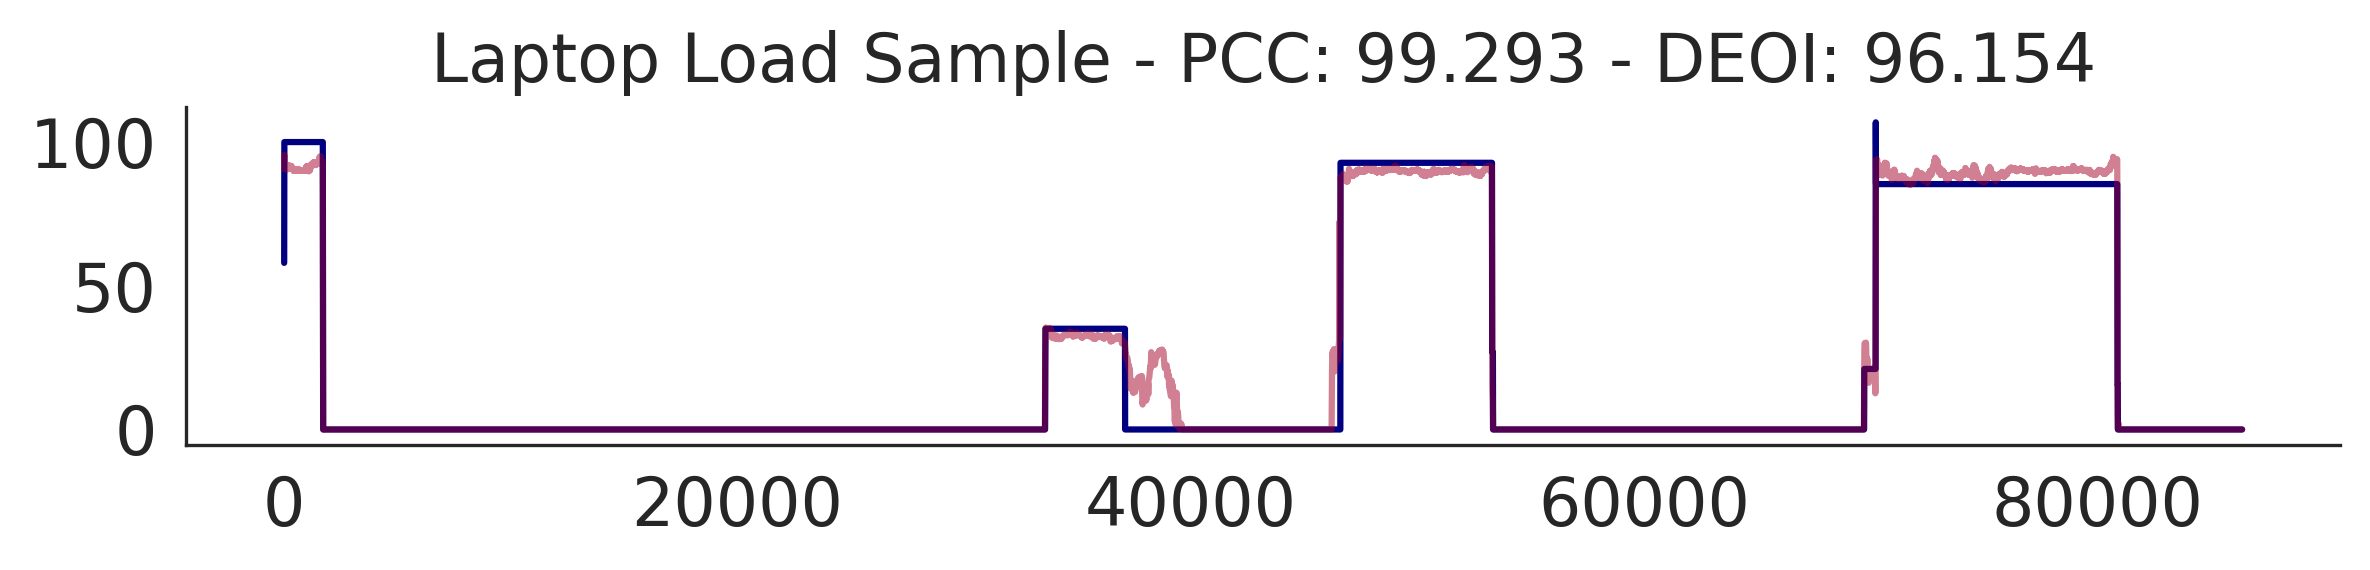

In [284]:
# Plot
data_shape = X_Test.shape
i = random.randint(0, data_shape[0])
i = 1
print(i)
fig, ax = plt.subplots(figsize=(8,2), dpi=300, layout='constrained', facecolor='white')
# Subplot 1 Data
Y_Test_Temp = np.expand_dims(np.expand_dims(Y_Test_Denorm[i,:,0], axis=0), axis=2)
Y_Pred_Temp = np.expand_dims(np.expand_dims(Y_Pred_Denorm[i,:,0], axis=0), axis=2)
t_ = np.arange(0, len(Y_Test_Temp.ravel()))*4
print(Y_Test_Temp.shape)
MAE, MSE, RMSE, R2C, PCC, CS, DEOI, JEOI = Evaluation_Metrics(Y_Test_Temp, Y_Pred_Temp)
#
ax.plot(t_, Y_Test_Temp.ravel(), label='GT', color='navy')
ax.plot(t_, Y_Pred_Temp.ravel(), label='Pred', color='#a50026', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.title(f"Laptop Load Sample - PCC: {PCC} - DEOI: {DEOI}", fontdict={'fontsize': 16})
# plt.legend()
plt.tight_layout()

### Load Stove Data

In [118]:
fl_Data = h5py.File(os.path.join('Outcomes/Phase_1/DAGG_Net/UNet4P_5_32_DS_Stove_SM3_21600_Overlapped.h5'), 'r')
print(fl_Data.keys())
X_Test = fl_Data['SM']
Y_Test = fl_Data['App']
Y_Pred = fl_Data['App_Pred']
Y_Test_Denorm = fl_Data['App_Denorm']
Y_Pred_Denorm = fl_Data['App_Pred_Denorm']
#
X_Test_Stove = X_Test[1,:,1]*10000
Y_Test_Stove = Y_Test_Denorm[1,:,0]
Y_Pred_Stove = Y_Pred_Denorm[1,:,0]

<KeysViewHDF5 ['App', 'App_Denorm', 'App_Pred', 'App_Pred_Denorm', 'SM']>


2
(1, 21600, 1)
(1, 21600, 1)
(1, 21600, 1)
MAE Error: 7.01 +/- 0.0
MSE Error: 3226.377 +/- 0.0
RMSE Error: 56.801 +/- 0.0
R-squared (R²) Score: 97.562% +/- 0.0
Pearson Correlation (PCC): 98.972% +/- 0.0
Cosine Similarity: 98.991% +/- 0.0
DSC or Dice Score: 93.269% +/- 0.0
IoU or Jaccard Score: 87.388% +/- 0.0


/tmp/ipykernel_39662/755048862.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


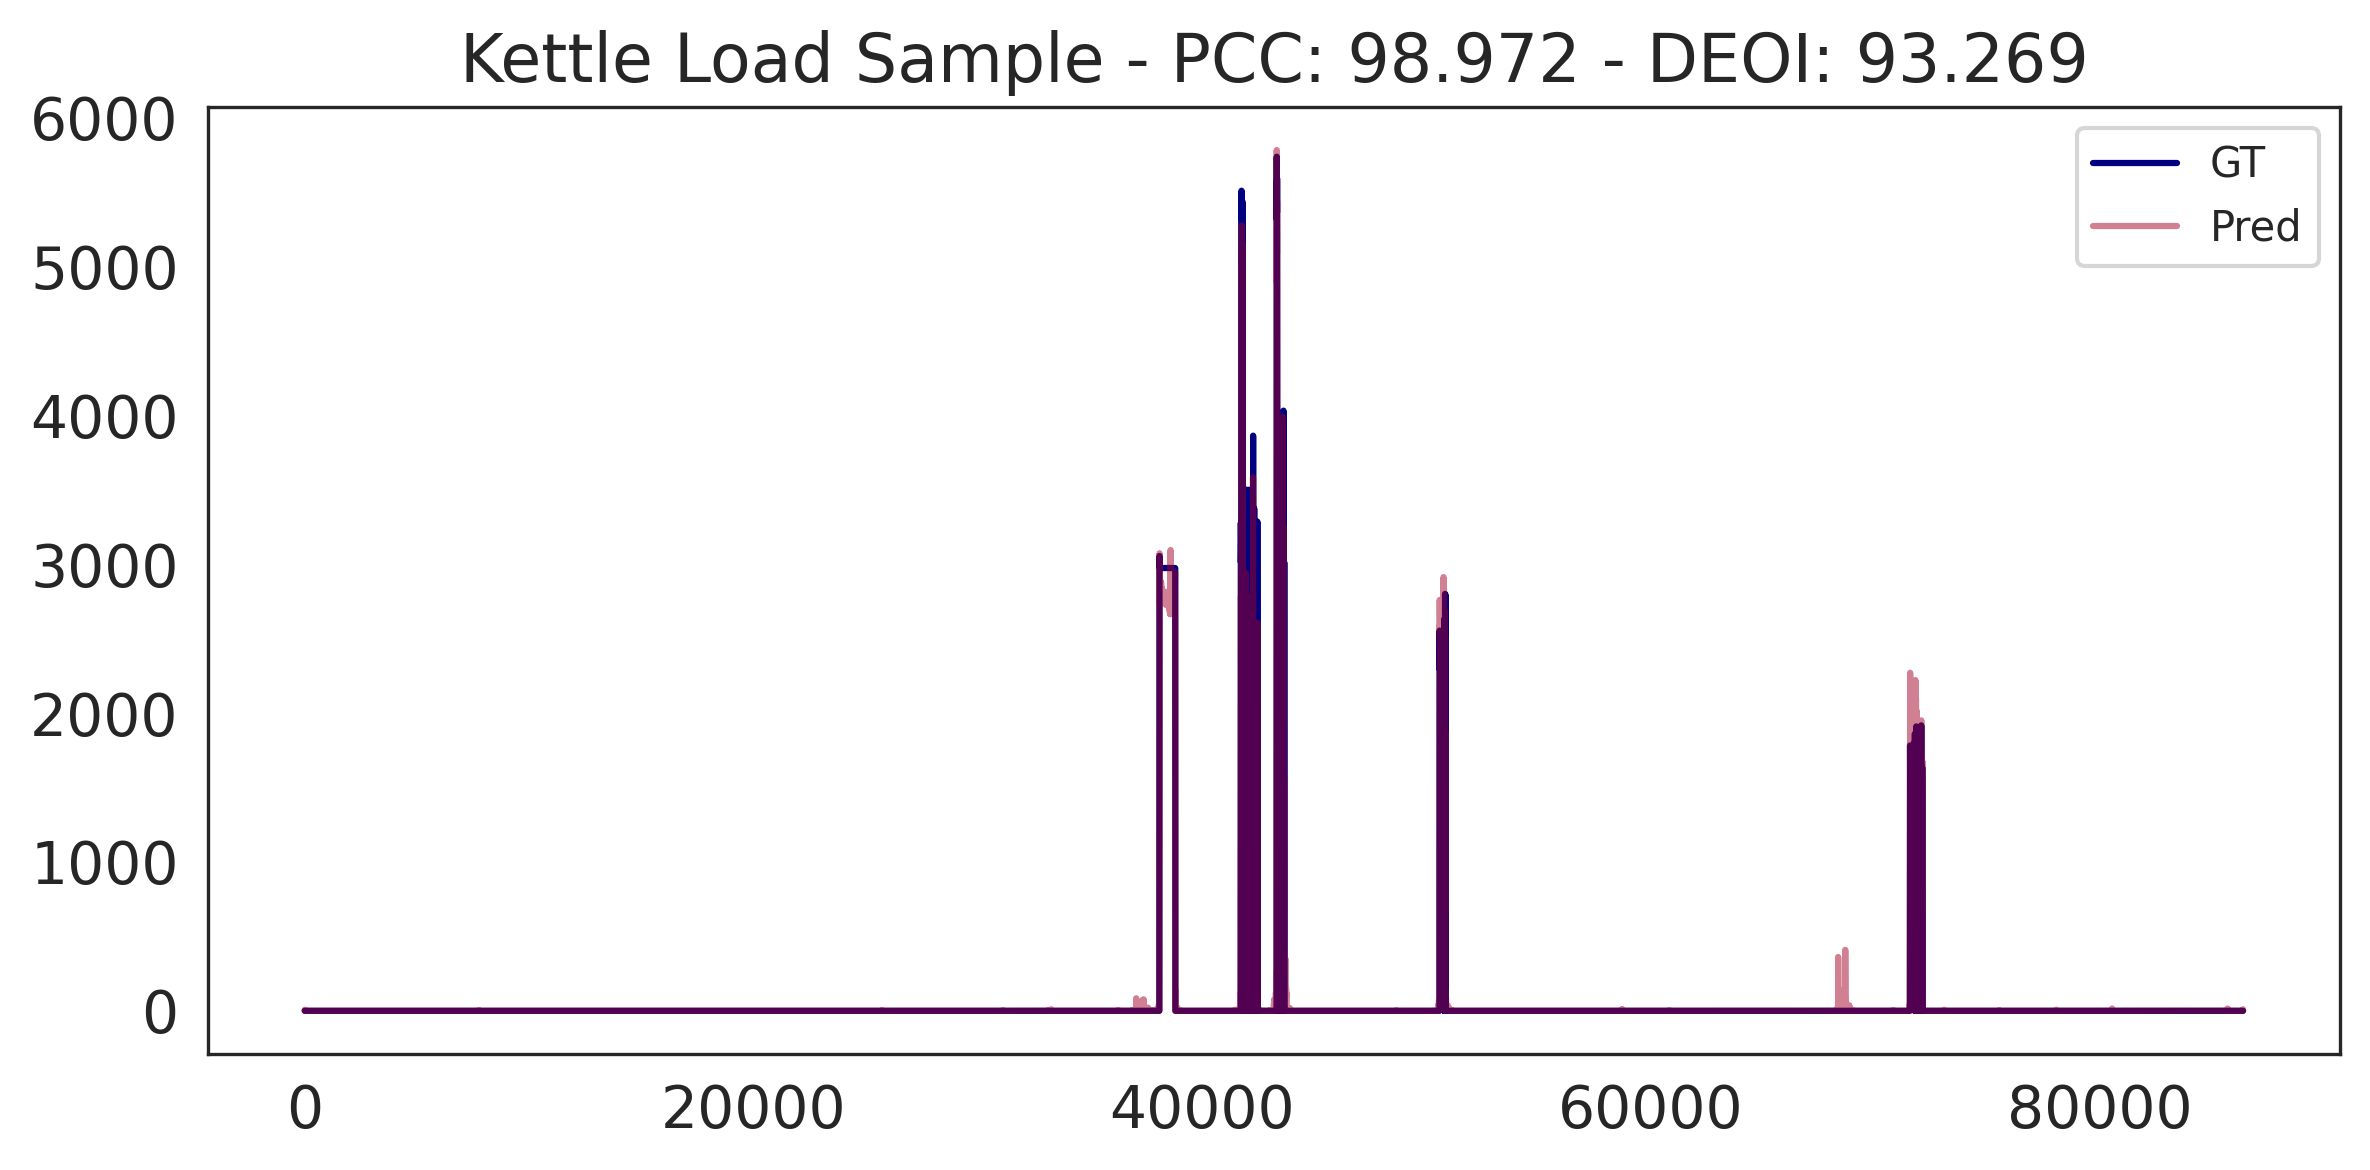

In [119]:
# Plot
data_shape = X_Test.shape
i = random.randint(0, data_shape[0])
print(i)
fig, ax = plt.subplots(figsize=(8,4), dpi=300, layout='constrained', facecolor='white')
# Subplot 1 Data
Y_Test_Temp = np.expand_dims(np.expand_dims(Y_Test_Denorm[i,:,0], axis=0), axis=2)
Y_Pred_Temp = np.expand_dims(np.expand_dims(Y_Pred_Denorm[i,:,0], axis=0), axis=2)
t_ = np.arange(0, len(Y_Test_Temp.ravel()))*4
print(Y_Test_Temp.shape)
MAE, MSE, RMSE, R2C, PCC, CS, DEOI, JEOI = Evaluation_Metrics(Y_Test_Temp, Y_Pred_Temp)
#
ax.plot(t_, Y_Test_Temp.ravel(), label='GT', color='navy')
ax.plot(t_, Y_Pred_Temp.ravel(), label='Pred', color='#a50026', alpha=0.5)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title(f"Kettle Load Sample - PCC: {PCC} - DEOI: {DEOI}", fontdict={'fontsize': 16})
plt.legend()
plt.tight_layout()

### Load Dryer Data

In [120]:
fl_Data = h5py.File(os.path.join('Outcomes/Phase_1/DAGG_Net/UNet4P_5_32_DS_Dryer_SM3_21600_Overlapped.h5'), 'r')
print(fl_Data.keys())
X_Test = fl_Data['SM']
Y_Test = fl_Data['App']
Y_Pred = fl_Data['App_Pred']
Y_Test_Denorm = fl_Data['App_Denorm']
Y_Pred_Denorm = fl_Data['App_Pred_Denorm']
#
X_Test_Dryer = X_Test[6,:,1]*1000
Y_Test_Dryer = Y_Test_Denorm[6,:,0]
Y_Pred_Dryer = Y_Pred_Denorm[6,:,0]

<KeysViewHDF5 ['App', 'App_Denorm', 'App_Pred', 'App_Pred_Denorm', 'SM']>


In [ ]:
# Plot
data_shape = X_Test.shape
i = random.randint(0, data_shape[0])
print(i)
fig, ax = plt.subplots(figsize=(8,4), dpi=300, layout='constrained', facecolor='white')
# Subplot 1 Data
Y_Test_Temp = np.expand_dims(np.expand_dims(Y_Test_Denorm[i,:,0], axis=0), axis=2)
Y_Pred_Temp = np.expand_dims(np.expand_dims(Y_Pred_Denorm[i,:,0], axis=0), axis=2)
t_ = np.arange(0, len(Y_Test_Temp.ravel()))*4
print(Y_Test_Temp.shape)
MAE, MSE, RMSE, R2C, PCC, CS, DEOI, JEOI = Evaluation_Metrics(Y_Test_Temp, Y_Pred_Temp)
#
ax.plot(t_, Y_Test_Temp.ravel(), label='GT', color='navy')
ax.plot(t_, Y_Pred_Temp.ravel(), label='Pred', color='#a50026', alpha=0.5)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title(f"Kettle Load Sample - PCC: {PCC} - DEOI: {DEOI}", fontdict={'fontsize': 16})
plt.legend()
plt.tight_layout()

### Load Kitchen Appliances Data

In [141]:
fl_Data = h5py.File(os.path.join('Outcomes/Phase_1/LDNet/LDNet_5_32_DS_Kitchen_Appliances_SM3_21600_Overlapped.h5'), 'r')
print(fl_Data.keys())
X_Test = fl_Data['SM']
Y_Test = fl_Data['App']
Y_Pred = fl_Data['App_Pred']
Y_Test_Denorm = fl_Data['App_Denorm']
Y_Pred_Denorm = fl_Data['App_Pred_Denorm']
#
X_Test_Kitchen_Appliances = X_Test[34,:,1]*3000
Y_Test_Kitchen_Appliances = Y_Test_Denorm[34,:,0]
Y_Pred_Kitchen_Appliances = Y_Pred_Denorm[34,:,0]

<KeysViewHDF5 ['App', 'App_Denorm', 'App_Pred', 'App_Pred_Denorm', 'SM']>


58
(1, 21600, 1)
(1, 21600, 1)
(1, 21600, 1)
MAE Error: 0.904 +/- 0.0
MSE Error: 604.468 +/- 0.0
RMSE Error: 24.586 +/- 0.0
R-squared (R²) Score: 83.325% +/- 0.0
Pearson Correlation (PCC): 91.351% +/- 0.0
Cosine Similarity: 91.38% +/- 0.0
DSC or Dice Score: 86.709% +/- 0.0
IoU or Jaccard Score: 76.537% +/- 0.0


/tmp/ipykernel_39662/755048862.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


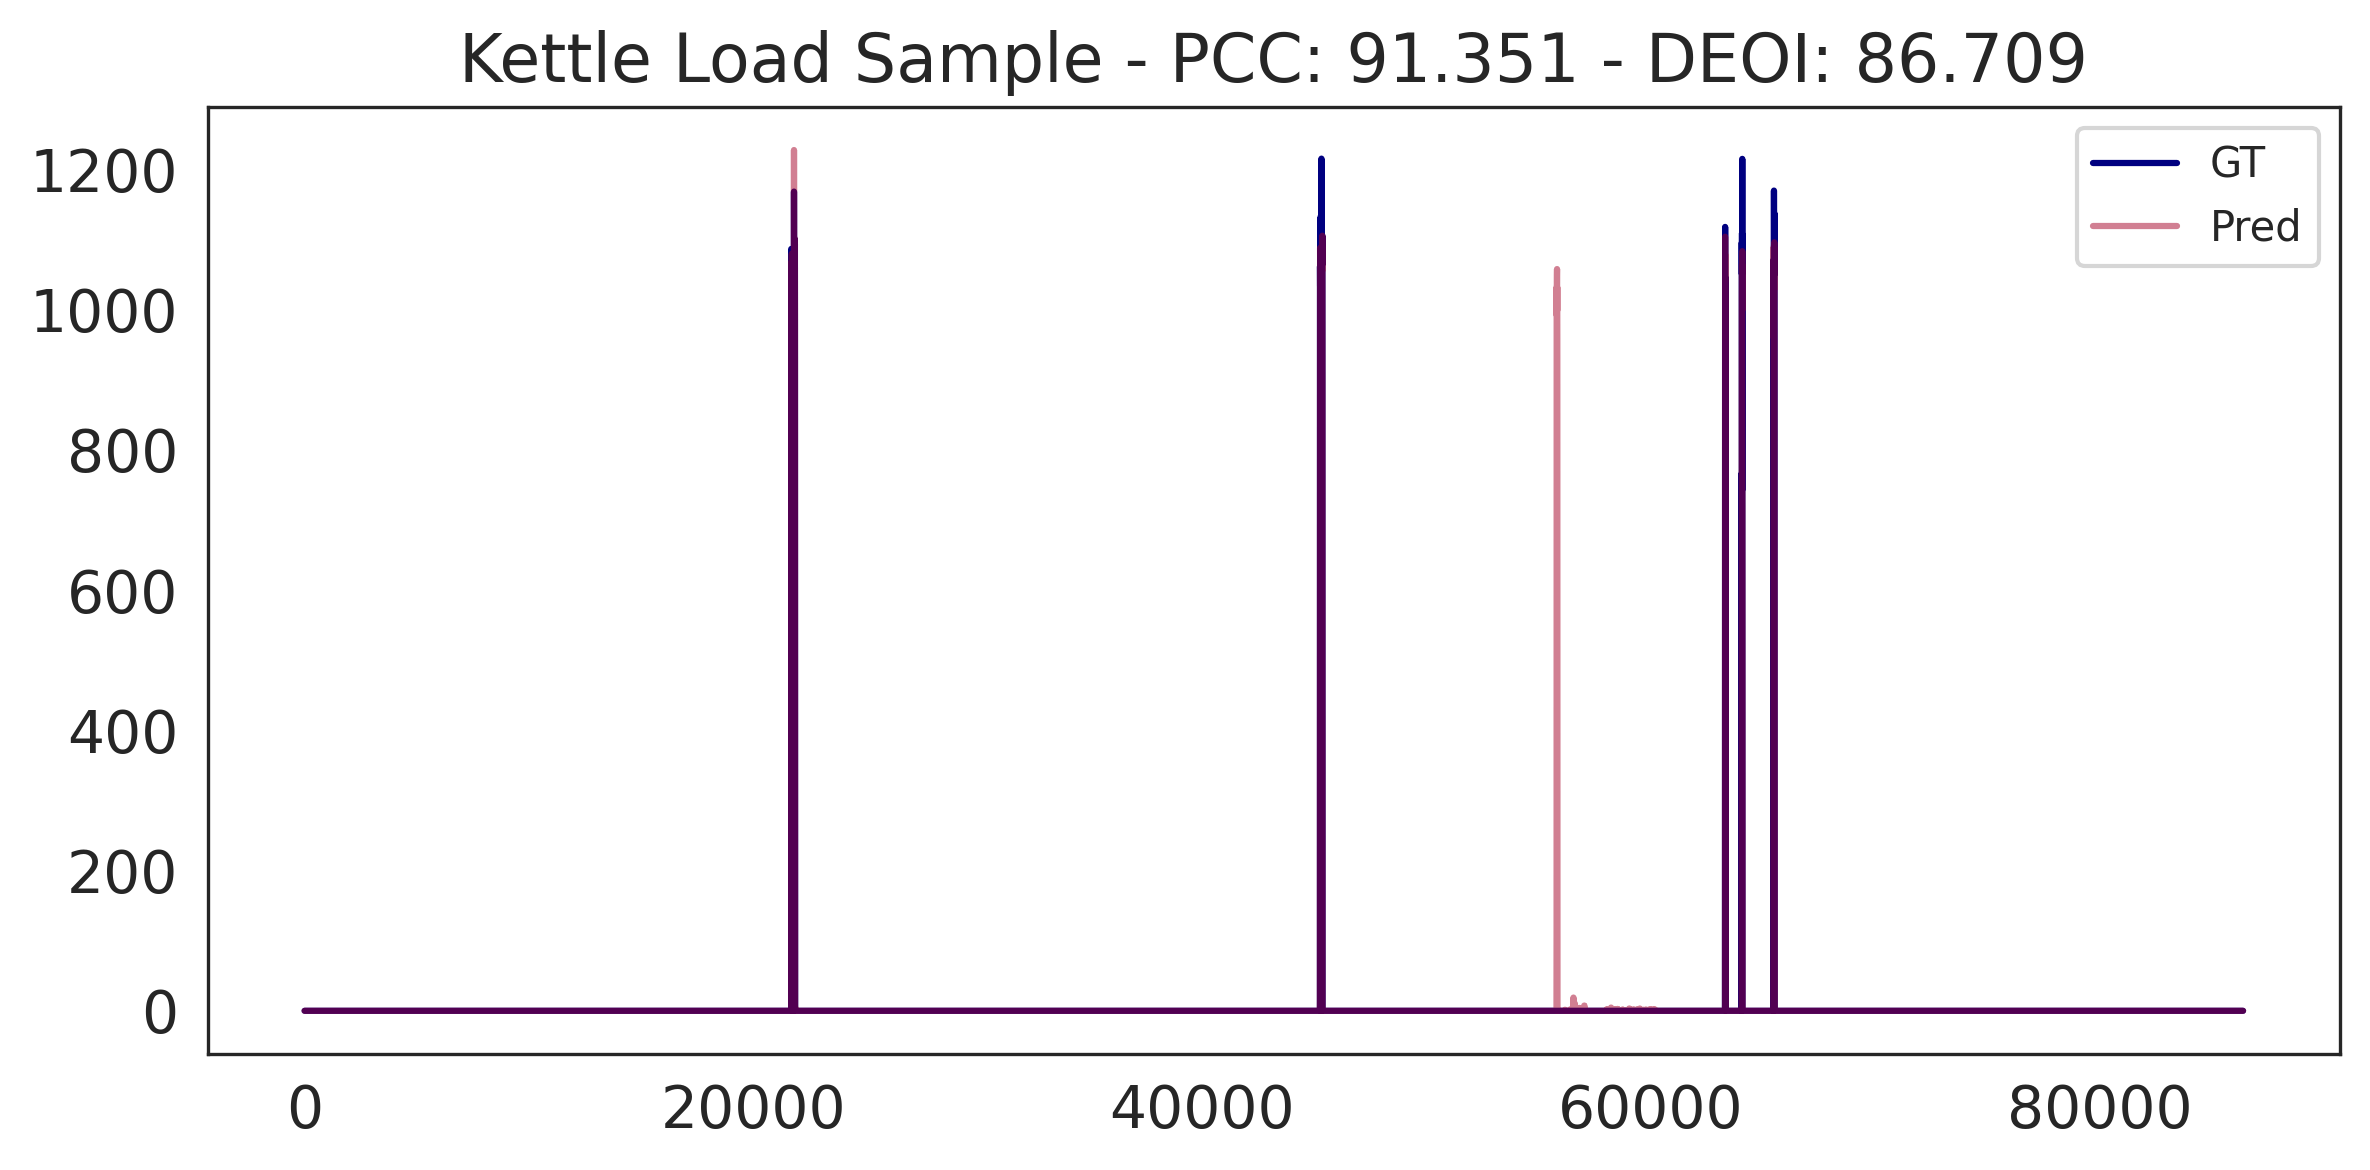

In [157]:
# Plot
data_shape = X_Test.shape
i = random.randint(0, data_shape[0])
print(i)
fig, ax = plt.subplots(figsize=(8,4), dpi=300, layout='constrained', facecolor='white')
# Subplot 1 Data
Y_Test_Temp = np.expand_dims(np.expand_dims(Y_Test_Denorm[i,:,0], axis=0), axis=2)
Y_Pred_Temp = np.expand_dims(np.expand_dims(Y_Pred_Denorm[i,:,0], axis=0), axis=2)
t_ = np.arange(0, len(Y_Test_Temp.ravel()))*4
print(Y_Test_Temp.shape)
MAE, MSE, RMSE, R2C, PCC, CS, DEOI, JEOI = Evaluation_Metrics(Y_Test_Temp, Y_Pred_Temp)
#
ax.plot(t_, Y_Test_Temp.ravel(), label='GT', color='navy')
ax.plot(t_, Y_Pred_Temp.ravel(), label='Pred', color='#a50026', alpha=0.5)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title(f"Kettle Load Sample - PCC: {PCC} - DEOI: {DEOI}", fontdict={'fontsize': 16})
plt.legend()
plt.tight_layout()

### Load Washing Machine Data

In [158]:
fl_Data = h5py.File(os.path.join('Outcomes/Phase_1/DAGG_Net/UNet4P_5_32_DS_Washing_Machine_SM3_21600_Overlapped.h5'), 'r')
print(fl_Data.keys())
X_Test = fl_Data['SM']
Y_Test = fl_Data['App']
Y_Pred = fl_Data['App_Pred']
Y_Test_Denorm = fl_Data['App_Denorm']
Y_Pred_Denorm = fl_Data['App_Pred_Denorm']
#
X_Test_Washing_Machine = X_Test[16,:,1]*2500
Y_Test_Washing_Machine = Y_Test_Denorm[16,:,0]
Y_Pred_Washing_Machine = Y_Pred_Denorm[16,:,0]

<KeysViewHDF5 ['App', 'App_Denorm', 'App_Pred', 'App_Pred_Denorm', 'SM']>


1
(1, 21600, 1)
(1, 21600, 1)
(1, 21600, 1)
MAE Error: 11.229 +/- 0.0
MSE Error: 10937.89 +/- 0.0
RMSE Error: 104.584 +/- 0.0
R-squared (R²) Score: 40.615% +/- 0.0
Pearson Correlation (PCC): 79.518% +/- 0.0
Cosine Similarity: 79.9% +/- 0.0
DSC or Dice Score: 75.438% +/- 0.0
IoU or Jaccard Score: 60.563% +/- 0.0


/tmp/ipykernel_39662/755048862.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


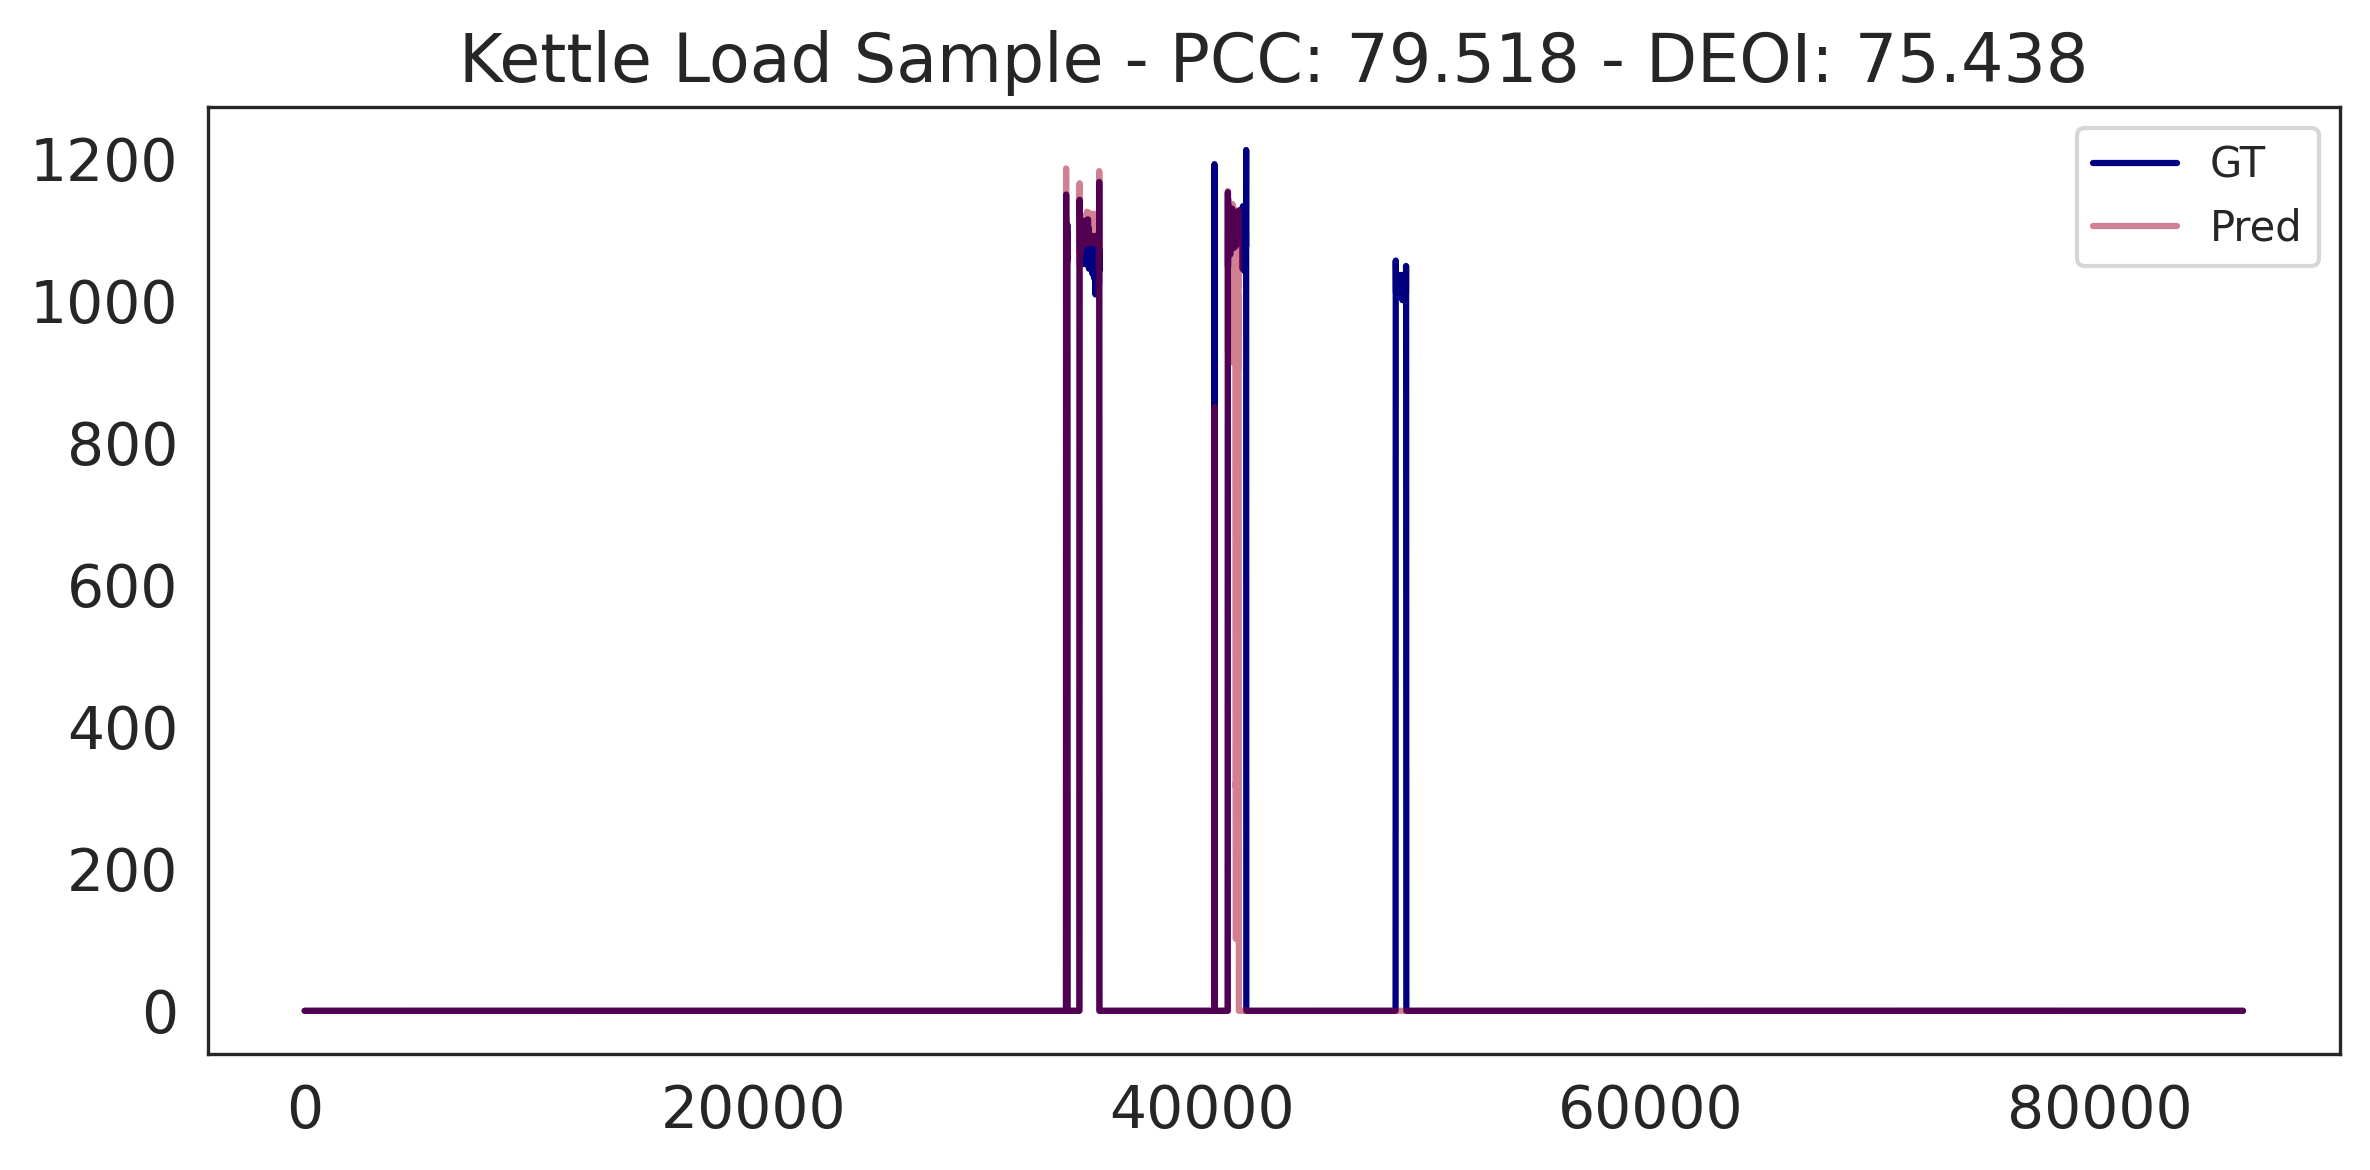

In [170]:
# Plot
data_shape = X_Test.shape
i = random.randint(0, data_shape[0])
print(i)
fig, ax = plt.subplots(figsize=(8,4), dpi=300, layout='constrained', facecolor='white')
# Subplot 1 Data
Y_Test_Temp = np.expand_dims(np.expand_dims(Y_Test_Denorm[i,:,0], axis=0), axis=2)
Y_Pred_Temp = np.expand_dims(np.expand_dims(Y_Pred_Denorm[i,:,0], axis=0), axis=2)
t_ = np.arange(0, len(Y_Test_Temp.ravel()))*4
print(Y_Test_Temp.shape)
MAE, MSE, RMSE, R2C, PCC, CS, DEOI, JEOI = Evaluation_Metrics(Y_Test_Temp, Y_Pred_Temp)
#
ax.plot(t_, Y_Test_Temp.ravel(), label='GT', color='navy')
ax.plot(t_, Y_Pred_Temp.ravel(), label='Pred', color='#a50026', alpha=0.5)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title(f"Kettle Load Sample - PCC: {PCC} - DEOI: {DEOI}", fontdict={'fontsize': 16})
plt.legend()
plt.tight_layout()

### Load PC and Router Data

In [171]:
fl_Data = h5py.File(os.path.join('Outcomes/Phase_1/DAGG_Net/UNet4P_5_32_DS_PC_Router_SM3_21600_Overlapped.h5'), 'r')
print(fl_Data.keys())
X_Test = fl_Data['SM']
Y_Test = fl_Data['App']
Y_Pred = fl_Data['App_Pred']
Y_Test_Denorm = fl_Data['App_Denorm']
Y_Pred_Denorm = fl_Data['App_Pred_Denorm']
#
X_Test_PC_Router = X_Test[16,:,1]*1000
Y_Test_PC_Router = Y_Test_Denorm[16,:,0]
Y_Pred_PC_Router = Y_Pred_Denorm[16,:,0]

<KeysViewHDF5 ['App', 'App_Denorm', 'App_Pred', 'App_Pred_Denorm', 'SM']>


2
(1, 21600, 1)
(1, 21600, 1)
(1, 21600, 1)
MAE Error: 0.166 +/- 0.0
MSE Error: 0.279 +/- 0.0
RMSE Error: 0.529 +/- 0.0
R-squared (R²) Score: 90.871% +/- 0.0
Pearson Correlation (PCC): 96.223% +/- 0.0
Cosine Similarity: 99.313% +/- 0.0
DSC or Dice Score: 97.854% +/- 0.0
IoU or Jaccard Score: 95.799% +/- 0.0


/tmp/ipykernel_39662/755048862.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


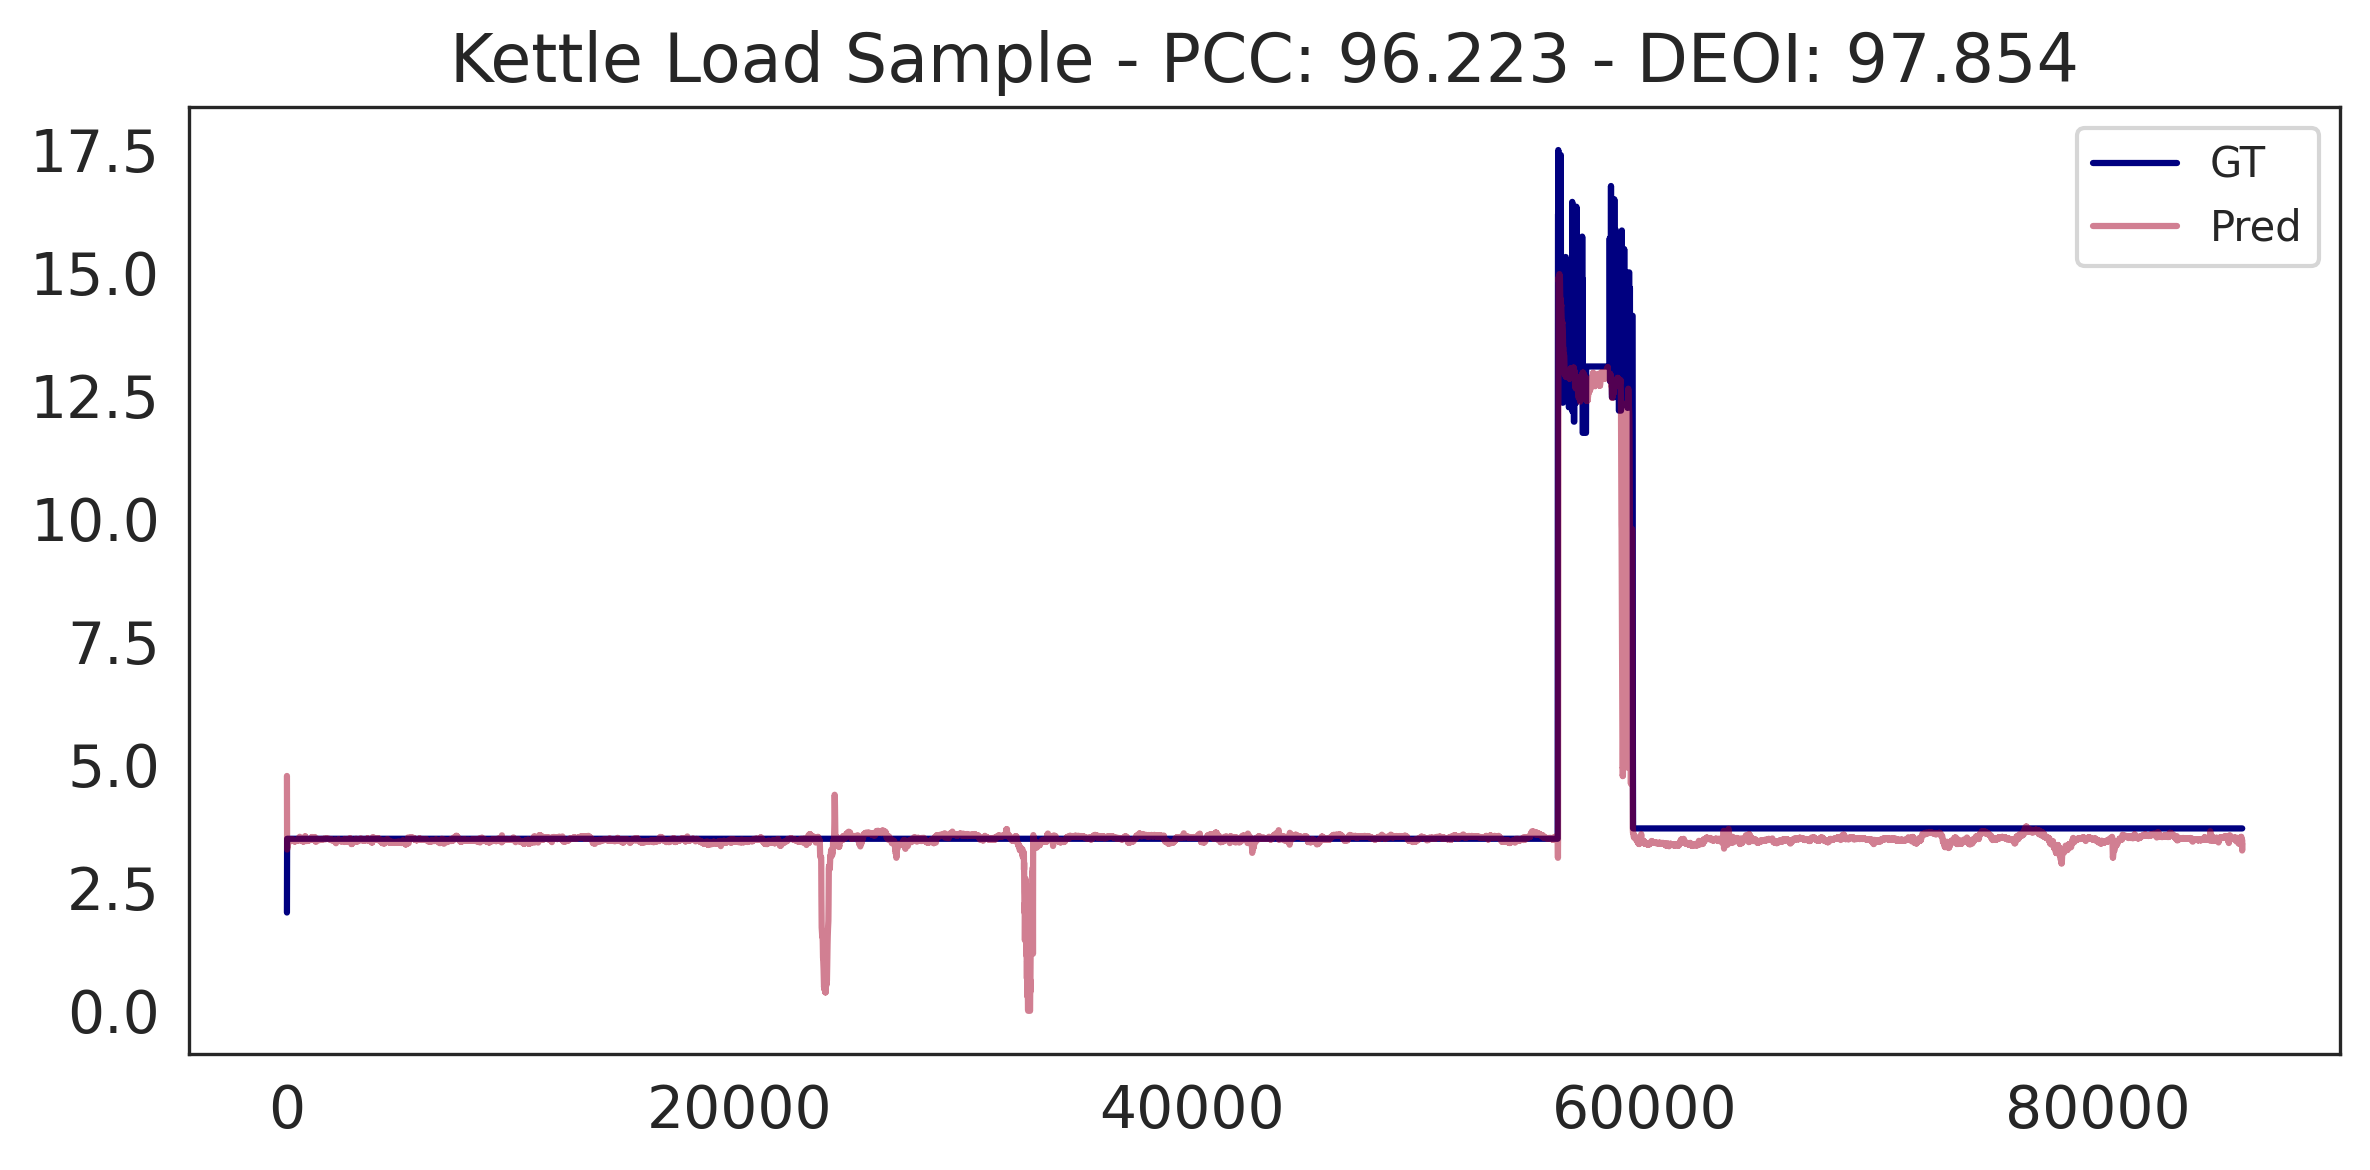

In [179]:
# Plot
data_shape = X_Test.shape
i = random.randint(0, data_shape[0])
print(i)
fig, ax = plt.subplots(figsize=(8,4), dpi=300, layout='constrained', facecolor='white')
# Subplot 1 Data
Y_Test_Temp = np.expand_dims(np.expand_dims(Y_Test_Denorm[i,:,0], axis=0), axis=2)
Y_Pred_Temp = np.expand_dims(np.expand_dims(Y_Pred_Denorm[i,:,0], axis=0), axis=2)
t_ = np.arange(0, len(Y_Test_Temp.ravel()))*4
print(Y_Test_Temp.shape)
MAE, MSE, RMSE, R2C, PCC, CS, DEOI, JEOI = Evaluation_Metrics(Y_Test_Temp, Y_Pred_Temp)
#
ax.plot(t_, Y_Test_Temp.ravel(), label='GT', color='navy')
ax.plot(t_, Y_Pred_Temp.ravel(), label='Pred', color='#a50026', alpha=0.5)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title(f"Kettle Load Sample - PCC: {PCC} - DEOI: {DEOI}", fontdict={'fontsize': 16})
plt.legend()
plt.tight_layout()

### Load Microwave Data

In [180]:
fl_Data = h5py.File(os.path.join('Outcomes/Phase_1/DAGG_Net/UNet4P_5_32_DS_Microwave_SM3_21600_Overlapped.h5'), 'r')
print(fl_Data.keys())
X_Test = fl_Data['SM']
Y_Test = fl_Data['App']
Y_Pred = fl_Data['App_Pred']
Y_Test_Denorm = fl_Data['App_Denorm']
Y_Pred_Denorm = fl_Data['App_Pred_Denorm']
#
X_Test_Microwave = X_Test[15,:,1]*3000
Y_Test_Microwave = Y_Test_Denorm[15,:,0]
Y_Pred_Microwave = Y_Pred_Denorm[15,:,0]

<KeysViewHDF5 ['App', 'App_Denorm', 'App_Pred', 'App_Pred_Denorm', 'SM']>


22
(1, 21600, 1)
(1, 21600, 1)
(1, 21600, 1)
MAE Error: 43.314 +/- 0.0
MSE Error: 58885.512 +/- 0.0
RMSE Error: 242.663 +/- 0.0
R-squared (R²) Score: 23.199% +/- 0.0
Pearson Correlation (PCC): 50.668% +/- 0.0
Cosine Similarity: 51.537% +/- 0.0
DSC or Dice Score: 41.886% +/- 0.0
IoU or Jaccard Score: 26.491% +/- 0.0


/tmp/ipykernel_39662/755048862.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


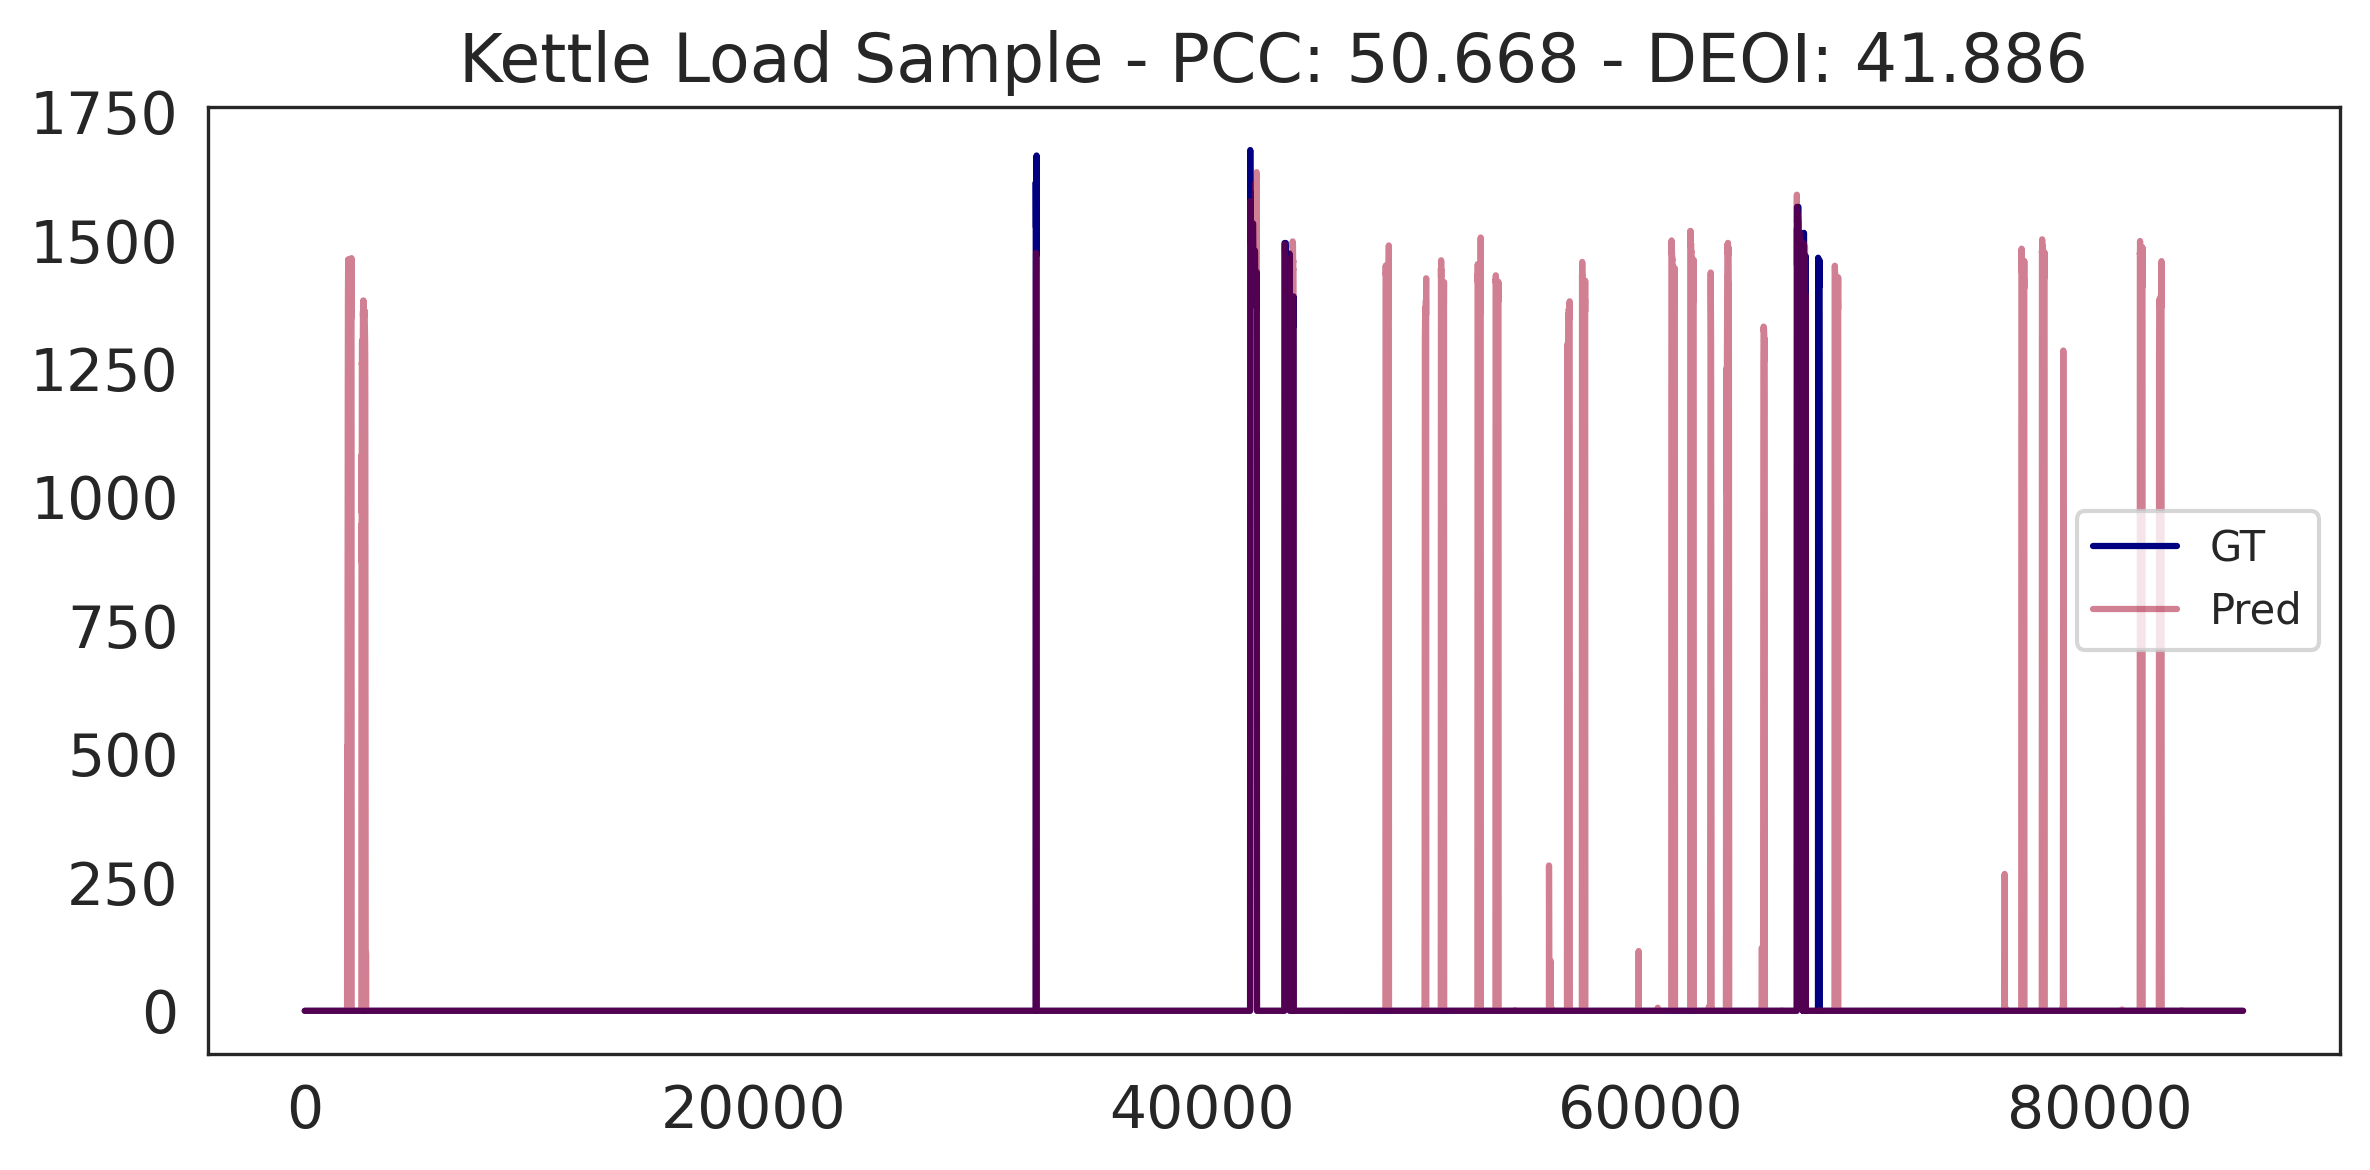

In [251]:
# Plot
data_shape = X_Test.shape
i = random.randint(0, data_shape[0])
print(i)
fig, ax = plt.subplots(figsize=(8,4), dpi=300, layout='constrained', facecolor='white')
# Subplot 1 Data
Y_Test_Temp = np.expand_dims(np.expand_dims(Y_Test_Denorm[i,:,0], axis=0), axis=2)
Y_Pred_Temp = np.expand_dims(np.expand_dims(Y_Pred_Denorm[i,:,0], axis=0), axis=2)
t_ = np.arange(0, len(Y_Test_Temp.ravel()))*4
print(Y_Test_Temp.shape)
MAE, MSE, RMSE, R2C, PCC, CS, DEOI, JEOI = Evaluation_Metrics(Y_Test_Temp, Y_Pred_Temp)
#
ax.plot(t_, Y_Test_Temp.ravel(), label='GT', color='navy')
ax.plot(t_, Y_Pred_Temp.ravel(), label='Pred', color='#a50026', alpha=0.5)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title(f"Kettle Load Sample - PCC: {PCC} - DEOI: {DEOI}", fontdict={'fontsize': 16})
plt.legend()
plt.tight_layout()

## Sample Plot for Testing

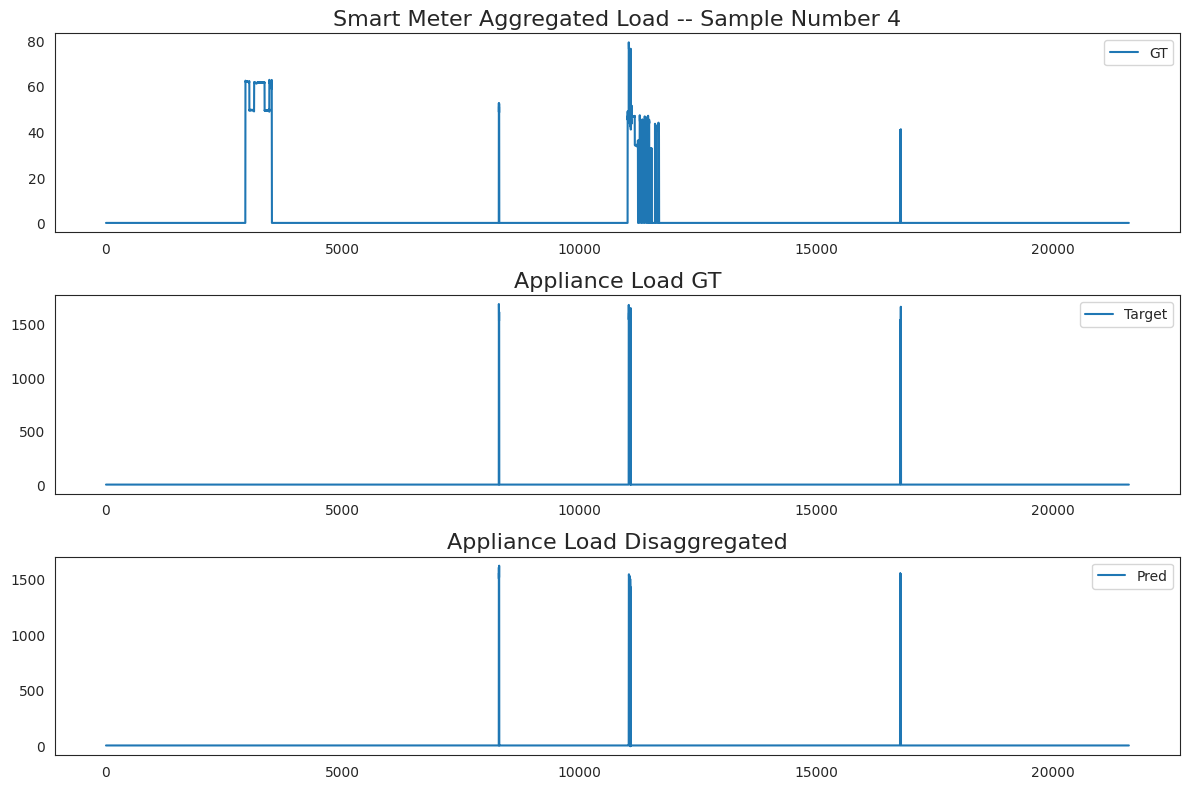

In [26]:
# Plot
data_shape = X_Test.shape
i = random.randint(0, data_shape[0])
plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.plot(X_Test[i,:,1]*100, label='GT')
# plt.ylim(0,1)
plt.title(f"Smart Meter Aggregated Load -- Sample Number {i}", fontdict={'fontsize': 16})
plt.legend()
plt.subplot(3,1,2)
plt.plot(Y_Test_Denorm[i,:,0], label='Target')
# plt.ylim(0,1)
plt.title(f"Appliance Load GT", fontdict={'fontsize': 16})
plt.legend()
plt.subplot(3,1,3)
plt.plot(Y_Pred_Denorm[i,:,0], label='Pred')
# plt.ylim(0,1)
plt.title(f"Appliance Load Disaggregated", fontdict={'fontsize': 16})
plt.legend()
plt.tight_layout()

## House 01

In [ ]:
segment_length = 21600
## Fridge
plt.figure(figsize=(32,16))
plt.subplot(7,3,1)
plt.plot(X_Test_Fridge, linewidth=3, label='SM GT', color='navy')
plt.title(f"House 01 - Smart Meter Power Three-Phase - Sample 30", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,2)
plt.plot(Y_Test_Fridge, linewidth=3, label='App GT', color='navy')
plt.title(f"House 01 - Fridge Load Consumption (Ground Truth) - Sample 30", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,3)
plt.plot(Y_Pred_Fridge, linewidth=3, label='App Pred', color='navy')
plt.title(f"House 01 - Disaggregated Fridge Load Consumption - Sample 30", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
## Freezer
plt.subplot(7,3,4)
plt.plot(X_Test_Freezer, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 22", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,5)
plt.plot(Y_Test_Freezer, linewidth=3, label='App GT', color='navy')
plt.title(f"Freezer Load Consumption (Ground Truth) - Sample 22", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,6)
plt.plot(Y_Pred_Freezer, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Freezer Load Consumption - Sample 22", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
## Kettle
plt.subplot(7,3,7)
plt.plot(X_Test_Kettle, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 42", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,8)
plt.plot(Y_Test_Kettle, linewidth=3, label='App GT', color='navy')
plt.title(f"Kettle Load Consumption (Ground Truth) - Sample 42", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,9)
plt.plot(Y_Pred_Kettle, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Kettle Load Consumption - Sample 42", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
## Dryer
plt.subplot(7,3,10)
plt.plot(X_Test_Dryer, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 12", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,11)
plt.plot(Y_Test_Dryer, linewidth=3, label='App GT', color='navy')
plt.title(f"Dryer Load Consumption (Ground Truth) - Sample 12", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,12)
plt.plot(Y_Pred_Dryer, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Dryer Load Consumption - Sample 12", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
## Kitchen Appliances
plt.subplot(7,3,13)
plt.plot(X_Test_Kitchen_Appliances, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 83", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,14)
plt.plot(Y_Test_Kitchen_Appliances, linewidth=3, label='App GT', color='navy')
plt.title(f"Kitchen Appliances Load Consumption (Ground Truth) - Sample 83", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,15)
plt.plot(Y_Pred_Kitchen_Appliances, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Kitchen Appliances Load Consumption - Sample 83", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
## Washing Machine
plt.subplot(7,3,16)
plt.plot(X_Test_Washing_Machine, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 13", fontdict={'fontsize': 22, 'fontweight': 2})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,17)
plt.plot(Y_Test_Washing_Machine, linewidth=3, label='App GT', color='navy')
plt.title(f"Washing Machine Load Consumption (Ground Truth) - Sample 13", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,18)
plt.plot(Y_Pred_Washing_Machine, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Washing Machine Load Consumption - Sample 13", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
## PC and Router
plt.subplot(7,3,19)
plt.plot(X_Test_PC_Router, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 16", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,20)
plt.plot(Y_Test_PC_Router, linewidth=3, label='App GT', color='navy')
plt.title(f"PC and Router Load Consumption (Ground Truth) - Sample 16", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,21)
plt.plot(Y_Pred_PC_Router, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated PC and Router Load Consumption - Sample 16", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

## House 02

In [ ]:
segment_length = 21600
'''Dishwasher'''
plt.figure(figsize=(32,21))
plt.subplot(9,3,1)
plt.plot(X_Test_Dishwasher, linewidth=3, label='SM GT', color='navy')
plt.title(f"House 02 - Smart Meter Power Three-Phase - Sample 5", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(9,3,2)
plt.plot(Y_Test_Dishwasher, linewidth=3, label='App GT', color='navy')
plt.title(f"House 02 - Dishwasher Load Consumption (Ground Truth) - Sample 5", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(9,3,3)
plt.plot(Y_Pred_Dishwasher, linewidth=3, label='App Pred', color='navy')
plt.title(f"House 02 - Disaggregated Dishwasher Load Consumption - Sample 5", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Air Exhaust'''
plt.subplot(9,3,4)
plt.plot(X_Test_Air_Exhaust, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 3", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(9,3,5)
plt.plot(Y_Test_Air_Exhaust, linewidth=3, label='App GT', color='navy')
plt.title(f"Air Exhaust Load Consumption (Ground Truth) - Sample 3", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(9,3,6)
plt.plot(Y_Pred_Air_Exhaust, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Air Exhaust Load Consumption - Sample 3", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Fridge'''
plt.subplot(9,3,7)
plt.plot(X_Test_Fridge, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 37", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(9,3,8)
plt.plot(Y_Test_Fridge, linewidth=3, label='App GT', color='navy')
plt.title(f"Fridge Load Consumption (Ground Truth) - Sample 37", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(9,3,9)
plt.plot(Y_Pred_Fridge, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Fridge Load Consumption - Sample 37", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Entertainment'''
plt.subplot(9,3,10)
plt.plot(X_Test_Entertainment, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 44", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(9,3,11)
plt.plot(Y_Test_Entertainment, linewidth=3, label='App GT', color='navy')
plt.title(f"Entertainment Load Consumption (Ground Truth) - Sample 44", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(9,3,12)
plt.plot(Y_Pred_Entertainment, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Entertainment Load Consumption - Sample 44", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Freezer'''
plt.subplot(9,3,13)
plt.plot(X_Test_Freezer, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 34", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(9,3,14)
plt.plot(Y_Test_Freezer, linewidth=3, label='App GT', color='navy')
plt.title(f"Freezer Load Consumption (Ground Truth) - Sample 34", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(9,3,15)
plt.plot(Y_Pred_Freezer, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Freezer Load Consumption - Sample 34", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Kettle'''
plt.subplot(9,3,16)
plt.plot(X_Test_Kettle, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 49", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(9,3,17)
plt.plot(Y_Test_Kettle, linewidth=3, label='App GT', color='navy')
plt.title(f"Kettle Load Consumption (Ground Truth) - Sample 49", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(9,3,18)
plt.plot(Y_Pred_Kettle, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Kettle Load Consumption - Sample 49", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Lamp'''
plt.subplot(9,3,19)
plt.plot(X_Test_Lamp, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 33", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(9,3,20)
plt.plot(Y_Test_Lamp, linewidth=3, label='App GT', color='navy')
plt.title(f"Lamp Load Consumption (Ground Truth) - Sample 33", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(9,3,21)
plt.plot(Y_Pred_Lamp, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Lamp Load Consumption - Sample 33", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Laptop'''
plt.subplot(9,3,22)
plt.plot(X_Test_Laptop, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 20", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(9,3,23)
plt.plot(Y_Test_Laptop, linewidth=3, label='App GT', color='navy')
plt.title(f"Laptop Load Consumption (Ground Truth) - Sample 20", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(9,3,24)
plt.plot(Y_Pred_Laptop, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Laptop Load Consumption - Sample 20", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Stove'''
plt.subplot(9,3,25)
plt.plot(X_Test_Stove, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 2", fontdict={'fontsize': 22, 'fontweight': 2})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(9,3,26)
plt.plot(Y_Test_Stove, linewidth=3, label='App GT', color='navy')
plt.title(f"Stove Load Consumption (Ground Truth) - Sample 2", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(9,3,27)
plt.plot(Y_Pred_Stove, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Stove Load Consumption - Sample 2", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

## House 03

In [ ]:
segment_length = 21600
plt.figure(figsize=(32,14))
'''Fridge'''
plt.subplot(6,3,1)
plt.plot(X_Test_Fridge, linewidth=3, label='SM GT', color='navy')
plt.title(f"House 03 - Smart Meter Power Three-Phase - Sample 23", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(6,3,2)
plt.plot(Y_Test_Fridge, linewidth=3, label='App GT', color='navy')
plt.title(f"House 03 - Fridge Load Consumption (Ground Truth) - Sample 23", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(6,3,3)
plt.plot(Y_Pred_Fridge, linewidth=3, label='App Pred', color='navy')
plt.title(f"House 03 - Disaggregated Fridge Load Consumption - Sample 23", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Entertainment'''
plt.subplot(6,3,4)
plt.plot(X_Test_Entertainment, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 37", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(6,3,5)
plt.plot(Y_Test_Entertainment, linewidth=3, label='App GT', color='navy')
plt.title(f"Entertainment Load Consumption (Ground Truth) - Sample 37", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(6,3,6)
plt.plot(Y_Pred_Entertainment, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Entertainment Load Consumption - Sample 37", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Freezer'''
plt.subplot(6,3,7)
plt.plot(X_Test_Freezer, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 11", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(6,3,8)
plt.plot(Y_Test_Freezer, linewidth=3, label='App GT', color='navy')
plt.title(f"Freezer Load Consumption (Ground Truth) - Sample 11", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(6,3,9)
plt.plot(Y_Pred_Freezer, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Freezer Load Consumption - Sample 11", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Kettle'''
plt.subplot(6,3,10)
plt.plot(X_Test_Kettle, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 62", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(6,3,11)
plt.plot(Y_Test_Kettle, linewidth=3, label='App GT', color='navy')
plt.title(f"Kettle Load Consumption (Ground Truth) - Sample 62", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(6,3,12)
plt.plot(Y_Pred_Kettle, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Kettle Load Consumption - Sample 62", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
## Kitchen Appliances
plt.subplot(6,3,13)
plt.plot(X_Test_Kitchen_Appliances, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 34", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(6,3,14)
plt.plot(Y_Test_Kitchen_Appliances, linewidth=3, label='App GT', color='navy')
plt.title(f"Kitchen Appliances Load Consumption (Ground Truth) - Sample 34", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(6,3,15)
plt.plot(Y_Pred_Kitchen_Appliances, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Kitchen Appliances Load Consumption - Sample 34", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
## PC and Router
plt.subplot(6,3,16)
plt.plot(X_Test_PC_Router, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 8", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(6,3,17)
plt.plot(Y_Test_PC_Router, linewidth=3, label='App GT', color='navy')
plt.title(f"PC and Router Load Consumption (Ground Truth) - Sample 8", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(6,3,18)
plt.plot(Y_Pred_PC_Router, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated PC and Router Load Consumption - Sample 8", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

## House 04

In [ ]:
segment_length = 21600
plt.figure(figsize=(32,16))
'''Fridge'''
plt.subplot(7,3,1)
plt.plot(X_Test_Fridge, linewidth=3, label='SM GT', color='navy')
plt.title(f"House 04 - Smart Meter Power Three-Phase - Sample 31", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,2)
plt.plot(Y_Test_Fridge, linewidth=3, label='App GT', color='navy')
plt.title(f"House 04 - Fridge Load Consumption (Ground Truth) - Sample 31", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,3)
plt.plot(Y_Pred_Fridge, linewidth=3, label='App Pred', color='navy')
plt.title(f"House 04 - Disaggregated Fridge Load Consumption - Sample 31", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Entertainment'''
plt.subplot(7,3,4)
plt.plot(X_Test_Entertainment, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 28", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,5)
plt.plot(Y_Test_Entertainment, linewidth=3, label='App GT', color='navy')
plt.title(f"Entertainment Load Consumption (Ground Truth) - Sample 28", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,6)
plt.plot(Y_Pred_Entertainment, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Entertainment Load Consumption - Sample 28", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Freezer'''
plt.subplot(7,3,7)
plt.plot(X_Test_Freezer, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 35", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,8)
plt.plot(Y_Test_Freezer, linewidth=3, label='App GT', color='navy')
plt.title(f"Freezer Load Consumption (Ground Truth) - Sample 35", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,9)
plt.plot(Y_Pred_Freezer, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Freezer Load Consumption - Sample 35", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Lamp'''
plt.subplot(7,3,10)
plt.plot(X_Test_Lamp, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 28", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,11)
plt.plot(Y_Test_Lamp, linewidth=3, label='App GT', color='navy')
plt.title(f"Lamp Load Consumption (Ground Truth) - Sample 28", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,12)
plt.plot(Y_Pred_Lamp, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Lamp Load Consumption - Sample 28", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Laptop'''
plt.subplot(7,3,13)
plt.plot(X_Test_Laptop, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 41", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,14)
plt.plot(Y_Test_Laptop, linewidth=3, label='App GT', color='navy')
plt.title(f"Laptop Load Consumption (Ground Truth) - Sample 41", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,15)
plt.plot(Y_Pred_Laptop, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Laptop Load Consumption - Sample 41", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
## Kitchen Appliances
plt.subplot(7,3,16)
plt.plot(X_Test_Kitchen_Appliances, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 59", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,17)
plt.plot(Y_Test_Kitchen_Appliances, linewidth=3, label='App GT', color='navy')
plt.title(f"Kitchen Appliances Load Consumption (Ground Truth) - Sample 59", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,18)
plt.plot(Y_Pred_Kitchen_Appliances, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Kitchen Appliances Load Consumption - Sample 59", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
## Microwave
plt.subplot(7,3,19)
plt.plot(X_Test_Microwave, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 32", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,20)
plt.plot(Y_Test_Microwave, linewidth=3, label='App GT', color='navy')
plt.title(f"Microwave Load Consumption (Ground Truth) - Sample 32", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,21)
plt.plot(Y_Pred_Microwave, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Microwave Load Consumption - Sample 32", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

## House 05

In [ ]:
segment_length = 21600
plt.figure(figsize=(32,14))
'''Fridge'''
plt.subplot(6,3,1)
plt.plot(X_Test_Fridge, linewidth=3, label='SM GT', color='navy')
plt.title(f"House 05 - Smart Meter Power Three-Phase - Sample 46", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(6,3,2)
plt.plot(Y_Test_Fridge, linewidth=3, label='App GT', color='navy')
plt.title(f"House 05 - Fridge Load Consumption (Ground Truth) - Sample 46", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(6,3,3)
plt.plot(Y_Pred_Fridge, linewidth=3, label='App Pred', color='navy')
plt.title(f"House 05 - Disaggregated Fridge Load Consumption - Sample 46", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Entertainment'''
plt.subplot(6,3,4)
plt.plot(X_Test_Entertainment, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 1", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(6,3,5)
plt.plot(Y_Test_Entertainment, linewidth=3, label='App GT', color='navy')
plt.title(f"Entertainment Load Consumption (Ground Truth) - Sample 1", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(6,3,6)
plt.plot(Y_Pred_Entertainment, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Entertainment Load Consumption - Sample 1", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Kettle'''
plt.subplot(6,3,7)
plt.plot(X_Test_Kettle, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 13", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(6,3,8)
plt.plot(Y_Test_Kettle, linewidth=3, label='App GT', color='navy')
plt.title(f"Kettle Load Consumption (Ground Truth) - Sample 13", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(6,3,9)
plt.plot(Y_Pred_Kettle, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Kettle Load Consumption - Sample 13", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Kitchen Appliances'''
plt.subplot(6,3,10)
plt.plot(X_Test_Kitchen_Appliances, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 0", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(6,3,11)
plt.plot(Y_Test_Kitchen_Appliances, linewidth=3, label='App GT', color='navy')
plt.title(f"Kitchen Appliances Load Consumption (Ground Truth) - Sample 0", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(6,3,12)
plt.plot(Y_Pred_Kitchen_Appliances, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Kitchen Appliances Load Consumption - Sample 0", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
## PC and Router
plt.subplot(6,3,13)
plt.plot(X_Test_PC_Router, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 19", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(6,3,14)
plt.plot(Y_Test_PC_Router, linewidth=3, label='App GT', color='navy')
plt.title(f"PC and Router Load Consumption (Ground Truth) - Sample 19", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(6,3,15)
plt.plot(Y_Pred_PC_Router, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated PC and Router Load Consumption - Sample 19", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
## Microwave
plt.subplot(6,3,16)
plt.plot(X_Test_Microwave, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 25", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(6,3,17)
plt.plot(Y_Test_Microwave, linewidth=3, label='App GT', color='navy')
plt.title(f"Microwave Load Consumption (Ground Truth) - Sample 25", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(6,3,18)
plt.plot(Y_Pred_Microwave, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Microwave Load Consumption - Sample 25", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

## House 06

In [ ]:
segment_length = 21600
plt.figure(figsize=(32,16))
'''Fridge'''
plt.subplot(7,3,1)
plt.plot(X_Test_Fridge, linewidth=3, label='SM GT', color='navy')
plt.title(f"House 06 - Smart Meter Power Three-Phase - Sample 22", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,2)
plt.plot(Y_Test_Fridge, linewidth=3, label='App GT', color='navy')
plt.title(f"House 06 - Fridge Load Consumption (Ground Truth) - Sample 22", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,3)
plt.plot(Y_Pred_Fridge, linewidth=3, label='App Pred', color='navy')
plt.title(f"House 06 - Disaggregated Fridge Load Consumption - Sample 22", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Entertainment'''
plt.subplot(7,3,4)
plt.plot(X_Test_Entertainment, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 79", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,5)
plt.plot(Y_Test_Entertainment, linewidth=3, label='App GT', color='navy')
plt.title(f"Entertainment Load Consumption (Ground Truth) - Sample 79", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,6)
plt.plot(Y_Pred_Entertainment, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Entertainment Load Consumption - Sample 79", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Kettle'''
plt.subplot(7,3,7)
plt.plot(X_Test_Kettle, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 48", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,8)
plt.plot(Y_Test_Kettle, linewidth=3, label='App GT', color='navy')
plt.title(f"Kettle Load Consumption (Ground Truth) - Sample 48", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,9)
plt.plot(Y_Pred_Kettle, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Kettle Load Consumption - Sample 48", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Lamp'''
plt.subplot(7,3,10)
plt.plot(X_Test_Lamp, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 18", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,11)
plt.plot(Y_Test_Lamp, linewidth=3, label='App GT', color='navy')
plt.title(f"Lamp Load Consumption (Ground Truth) - Sample 18", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,12)
plt.plot(Y_Pred_Lamp, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Lamp Load Consumption - Sample 18", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Laptop'''
plt.subplot(7,3,13)
plt.plot(X_Test_Laptop, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 6", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,14)
plt.plot(Y_Test_Laptop, linewidth=3, label='App GT', color='navy')
plt.title(f"Laptop Load Consumption (Ground Truth) - Sample 6", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,15)
plt.plot(Y_Pred_Laptop, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Laptop Load Consumption - Sample 6", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Kitchen Appliances'''
plt.subplot(7,3,16)
plt.plot(X_Test_Kitchen_Appliances, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 63", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,17)
plt.plot(Y_Test_Kitchen_Appliances, linewidth=3, label='App GT', color='navy')
plt.title(f"Kitchen Appliances Load Consumption (Ground Truth) - Sample 63", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,18)
plt.plot(Y_Pred_Kitchen_Appliances, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated Kitchen Appliances Load Consumption - Sample 63", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''PC and Router'''
plt.subplot(7,3,19)
plt.plot(X_Test_PC_Router, linewidth=3, label='SM GT', color='navy')
plt.title(f"Smart Meter Power Three-Phase - Sample 17", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,20)
plt.plot(Y_Test_PC_Router, linewidth=3, label='App GT', color='navy')
plt.title(f"PC and Router Appliances Load Consumption (Ground Truth) - Sample 17", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(7,3,21)
plt.plot(Y_Pred_PC_Router, linewidth=3, label='App Pred', color='navy')
plt.title(f"Disaggregated PC and Router Appliances Load Consumption - Sample 17", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()


## General Plot

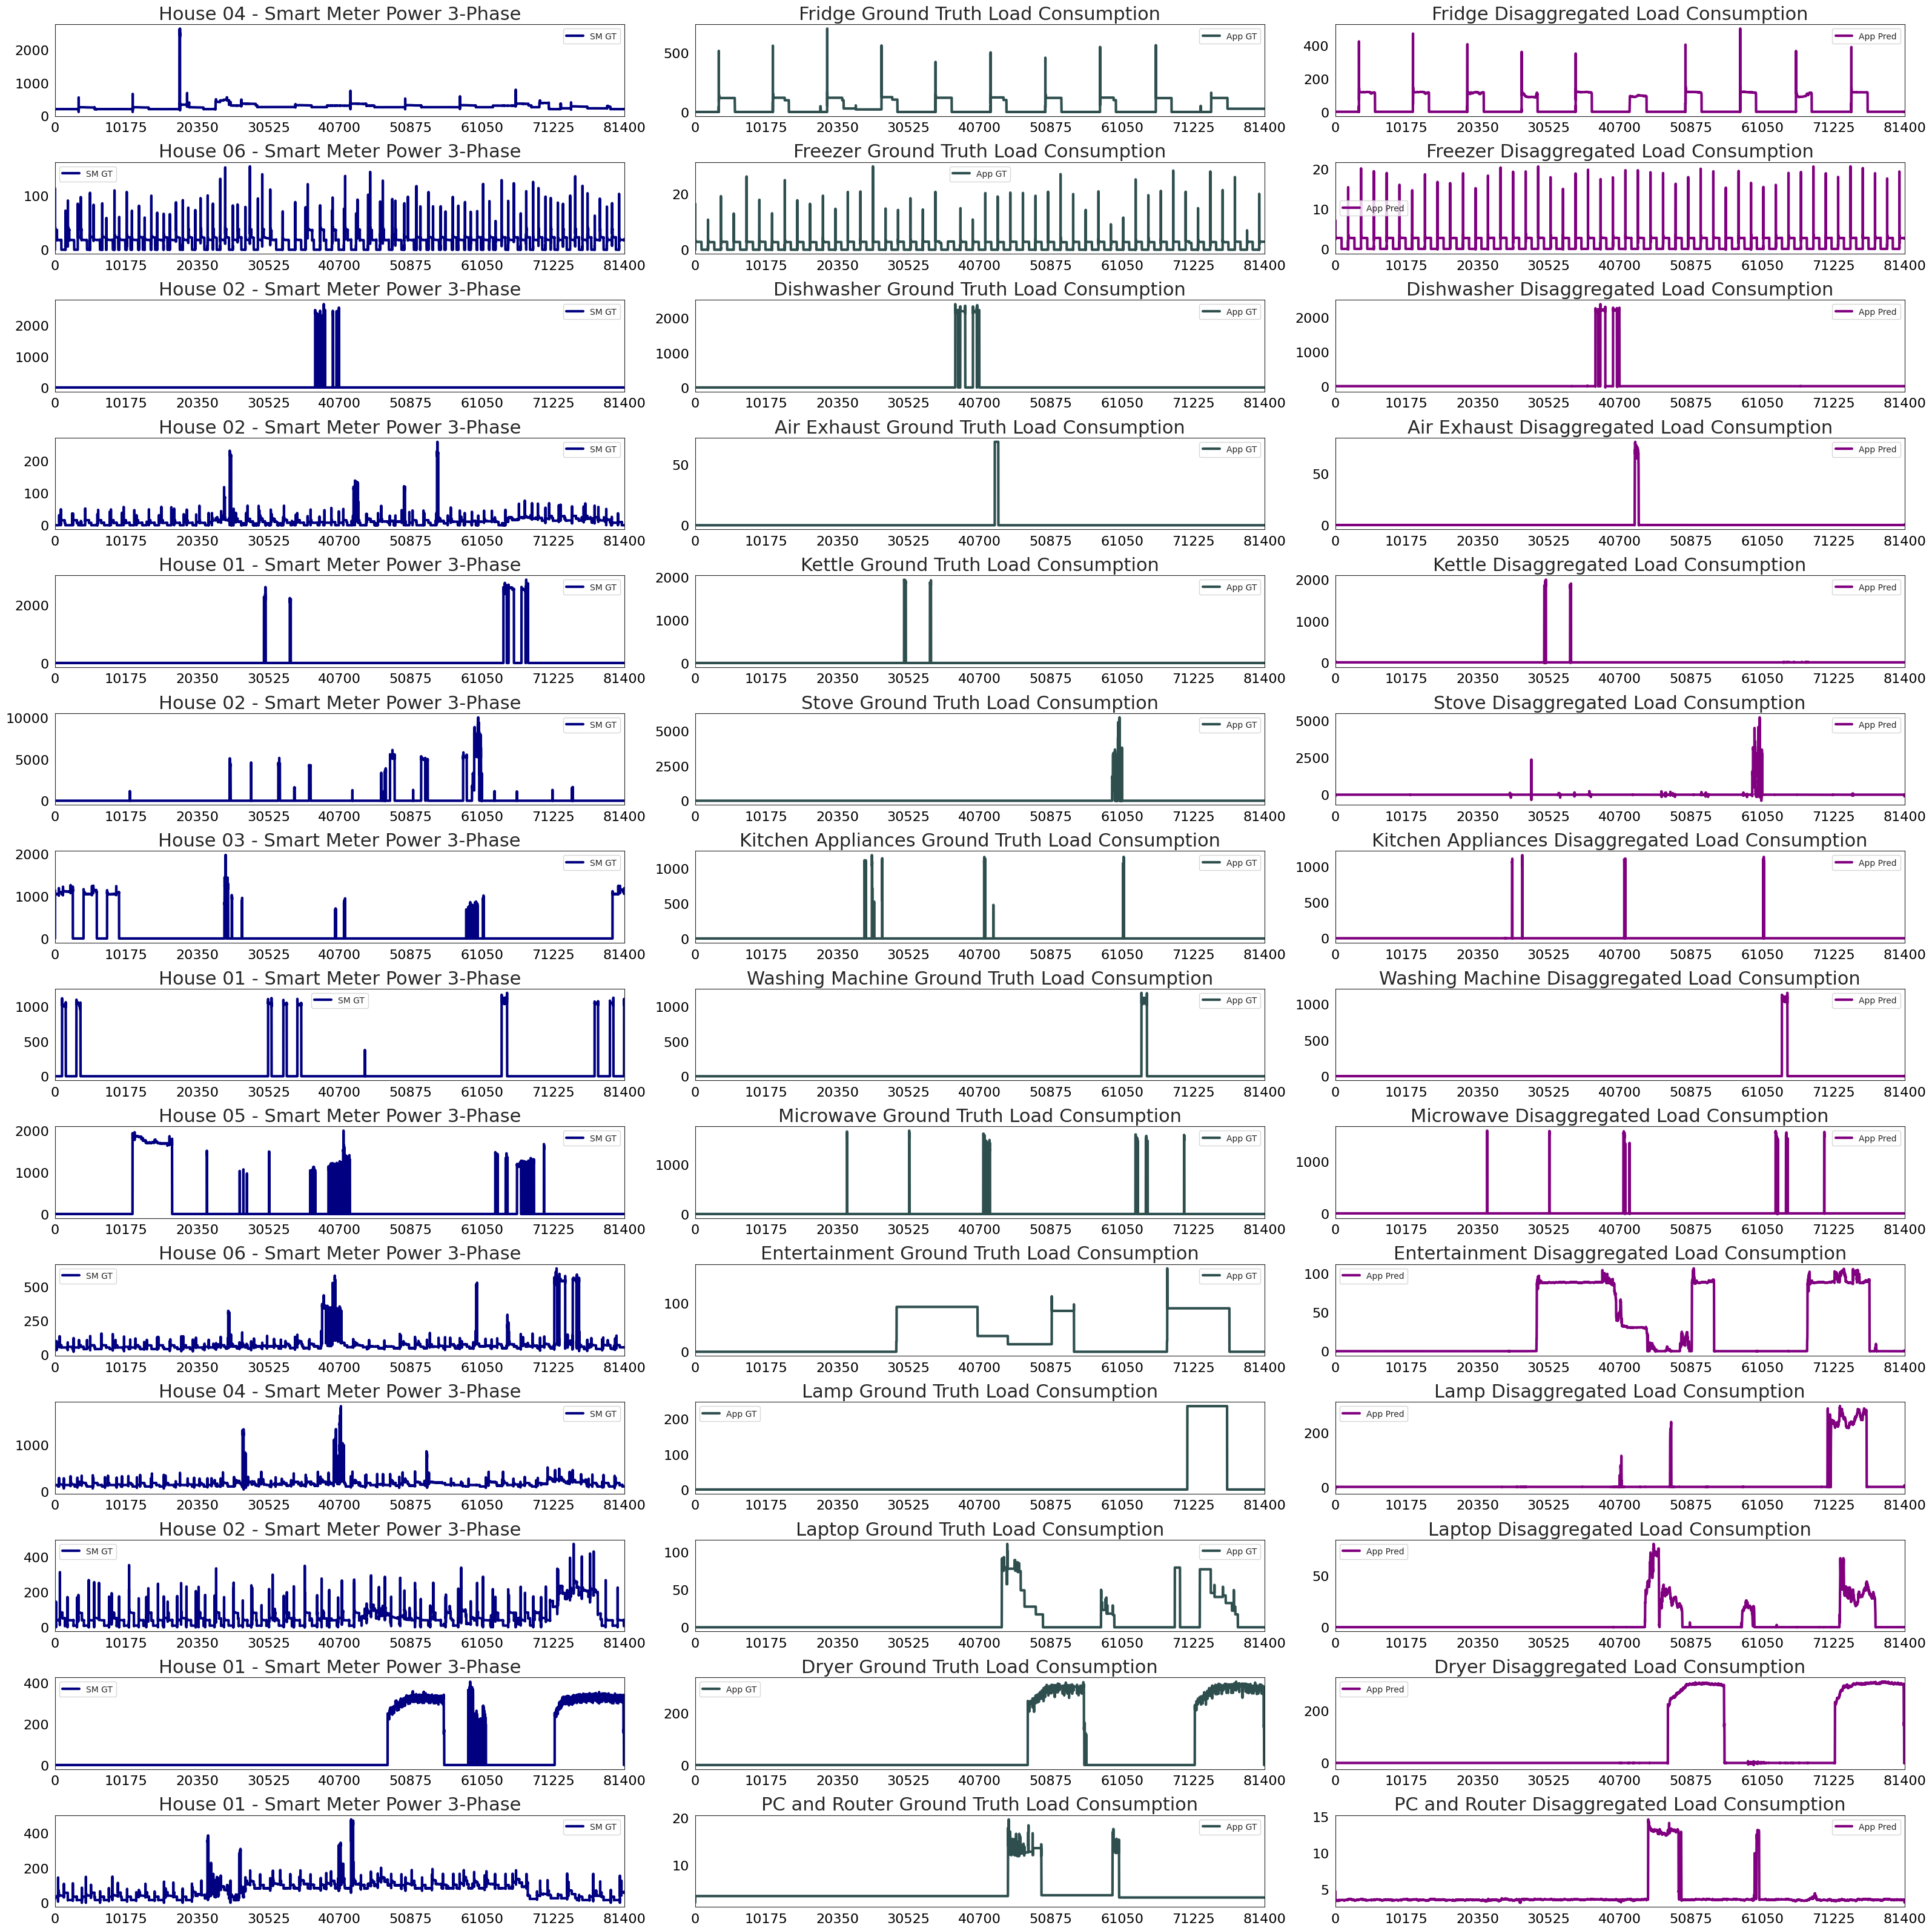

In [28]:
segment_length = 21600
x_ticks = np.linspace(0,segment_length,num=9,dtype=int)
x_ticks_labels = np.linspace(0,81400,num=9,dtype=int)
'''Fridge'''
plt.figure(figsize=(32,32))
plt.subplot(14,3,1)
plt.plot(X_Test_Fridge, linewidth=3, label='SM GT', color='navy')
plt.title(f"House 04 - Smart Meter Power 3-Phase", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(14,3,2)
plt.plot(Y_Test_Fridge, linewidth=3, label='App GT', color='darkslategrey')
plt.title(f"Fridge Ground Truth Load Consumption", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(14,3,3)
plt.plot(Y_Pred_Fridge, linewidth=3, label='App Pred', color='purple')
plt.title(f"Fridge Disaggregated Load Consumption", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

'''Freezer'''
plt.subplot(14,3,4)
plt.plot(X_Test_Freezer, linewidth=3, label='SM GT', color='navy')
plt.title(f"House 06 - Smart Meter Power 3-Phase", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(14,3,5)
plt.plot(Y_Test_Freezer, linewidth=3, label='App GT', color='darkslategrey')
plt.title(f"Freezer Ground Truth Load Consumption", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(14,3,6)
plt.plot(Y_Pred_Freezer, linewidth=3, label='App Pred', color='purple')
plt.title(f"Freezer Disaggregated Load Consumption", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

'''Dishwasher'''
plt.subplot(14,3,7)
plt.plot(X_Test_Dishwasher, linewidth=3, label='SM GT', color='navy')
plt.title(f"House 02 - Smart Meter Power 3-Phase", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(14,3,8)
plt.plot(Y_Test_Dishwasher, linewidth=3, label='App GT', color='darkslategrey')
plt.title(f"Dishwasher Ground Truth Load Consumption", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(14,3,9)
plt.plot(Y_Pred_Dishwasher, linewidth=3, label='App Pred', color='purple')
plt.title(f"Dishwasher Disaggregated Load Consumption", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

'''Air_Exhaust'''
plt.subplot(14,3,10)
plt.plot(X_Test_Air_Exhaust, linewidth=3, label='SM GT', color='navy')
plt.title(f"House 02 - Smart Meter Power 3-Phase", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(14,3,11)
plt.plot(Y_Test_Air_Exhaust, linewidth=3, label='App GT', color='darkslategrey')
plt.title(f"Air Exhaust Ground Truth Load Consumption", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(14,3,12)
plt.plot(Y_Pred_Air_Exhaust, linewidth=3, label='App Pred', color='purple')
plt.title(f"Air Exhaust Disaggregated Load Consumption", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

'''Kettle'''
plt.subplot(14,3,13)
plt.plot(X_Test_Kettle, linewidth=3, label='SM GT', color='navy')
plt.title(f"House 01 - Smart Meter Power 3-Phase", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(14,3,14)
plt.plot(Y_Test_Kettle, linewidth=3, label='App GT', color='darkslategrey')
plt.title(f"Kettle Ground Truth Load Consumption", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(14,3,15)
plt.plot(Y_Pred_Kettle, linewidth=3, label='App Pred', color='purple')
plt.title(f"Kettle Disaggregated Load Consumption", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

'''Stove'''
plt.subplot(14,3,16)
plt.plot(X_Test_Stove, linewidth=3, label='SM GT', color='navy')
plt.title(f"House 02 - Smart Meter Power 3-Phase", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(14,3,17)
plt.plot(Y_Test_Stove, linewidth=3, label='App GT', color='darkslategrey')
plt.title(f"Stove Ground Truth Load Consumption", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(14,3,18)
plt.plot(Y_Pred_Stove, linewidth=3, label='App Pred', color='purple')
plt.title(f"Stove Disaggregated Load Consumption", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

'''Kitchen Appliances'''
plt.subplot(14,3,19)
plt.plot(X_Test_Kitchen_Appliances, linewidth=3, label='SM GT', color='navy')
plt.title(f"House 03 - Smart Meter Power 3-Phase", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(14,3,20)
plt.plot(Y_Test_Kitchen_Appliances, linewidth=3, label='App GT', color='darkslategrey')
plt.title(f"Kitchen Appliances Ground Truth Load Consumption", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(14,3,21)
plt.plot(Y_Pred_Kitchen_Appliances, linewidth=3, label='App Pred', color='purple')
plt.title(f"Kitchen Appliances Disaggregated Load Consumption", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

'''Washing Machine'''
plt.subplot(14,3,22)
plt.plot(X_Test_Washing_Machine, linewidth=3, label='SM GT', color='navy')
plt.title(f"House 01 - Smart Meter Power 3-Phase", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(14,3,23)
plt.plot(Y_Test_Washing_Machine, linewidth=3, label='App GT', color='darkslategrey')
plt.title(f"Washing Machine Ground Truth Load Consumption", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(14,3,24)
plt.plot(Y_Pred_Washing_Machine, linewidth=3, label='App Pred', color='purple')
plt.title(f"Washing Machine Disaggregated Load Consumption", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

'''Microwave'''
plt.subplot(14,3,25)
plt.plot(X_Test_Microwave, linewidth=3, label='SM GT', color='navy')
plt.title(f"House 05 - Smart Meter Power 3-Phase", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(14,3,26)
plt.plot(Y_Test_Microwave, linewidth=3, label='App GT', color='darkslategrey')
plt.title(f"Microwave Ground Truth Load Consumption", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(14,3,27)
plt.plot(Y_Pred_Microwave, linewidth=3, label='App Pred', color='purple')
plt.title(f"Microwave Disaggregated Load Consumption", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

'''Entertainment'''
plt.subplot(14,3,28)
plt.plot(X_Test_Entertainment, linewidth=3, label='SM GT', color='navy')
plt.title(f"House 06 - Smart Meter Power 3-Phase", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(14,3,29)
plt.plot(Y_Test_Entertainment, linewidth=3, label='App GT', color='darkslategrey')
plt.title(f"Entertainment Ground Truth Load Consumption", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(14,3,30)
plt.plot(Y_Pred_Entertainment, linewidth=3, label='App Pred', color='purple')
plt.title(f"Entertainment Disaggregated Load Consumption", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

'''Lamp'''
plt.subplot(14,3,31)
plt.plot(X_Test_Lamp, linewidth=3, label='SM GT', color='navy')
plt.title(f"House 04 - Smart Meter Power 3-Phase", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(14,3,32)
plt.plot(Y_Test_Lamp, linewidth=3, label='App GT', color='darkslategrey')
plt.title(f"Lamp Ground Truth Load Consumption", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(14,3,33)
plt.plot(Y_Pred_Lamp, linewidth=3, label='App Pred', color='purple')
plt.title(f"Lamp Disaggregated Load Consumption", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

'''Laptop'''
plt.subplot(14,3,34)
plt.plot(X_Test_Laptop, linewidth=3, label='SM GT', color='navy')
plt.title(f"House 02 - Smart Meter Power 3-Phase", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(14,3,35)
plt.plot(Y_Test_Laptop, linewidth=3, label='App GT', color='darkslategrey')
plt.title(f"Laptop Ground Truth Load Consumption", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(14,3,36)
plt.plot(Y_Pred_Laptop, linewidth=3, label='App Pred', color='purple')
plt.title(f"Laptop Disaggregated Load Consumption", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

'''Dryer'''
plt.subplot(14,3,37)
plt.plot(X_Test_Dryer, linewidth=3, label='SM GT', color='navy')
plt.title(f"House 01 - Smart Meter Power 3-Phase", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(14,3,38)
plt.plot(Y_Test_Dryer, linewidth=3, label='App GT', color='darkslategrey')
plt.title(f"Dryer Ground Truth Load Consumption", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(14,3,39)
plt.plot(Y_Pred_Dryer, linewidth=3, label='App Pred', color='purple')
plt.title(f"Dryer Disaggregated Load Consumption", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

'''PC and Router'''
plt.subplot(14,3,40)
plt.plot(X_Test_PC_Router, linewidth=3, label='SM GT', color='navy')
plt.title(f"House 01 - Smart Meter Power 3-Phase", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(14,3,41)
plt.plot(Y_Test_PC_Router, linewidth=3, label='App GT', color='darkslategrey')
plt.title(f"PC and Router Ground Truth Load Consumption", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.subplot(14,3,42)
plt.plot(Y_Pred_PC_Router, linewidth=3, label='App Pred', color='purple')
plt.title(f"PC and Router Disaggregated Load Consumption", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.xticks(ticks=x_ticks,labels=x_ticks_labels)
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

Confusion Matrix

In [68]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
confusion_matrix_raw = np.array([[5106,672],[533,5298]])
confusion_matrix_norm = np.array([[0.88,0.12],[0.09,0.91]])
labels = ['1', '0']
print(confusion_matrix_raw)
def plot_conf_mat(confusion_matrix_raw, confusion_matrix_norm, labels):
  shape = confusion_matrix_raw.shape
  data = np.asarray(confusion_matrix_raw, dtype=int)
  text = np.asarray(confusion_matrix_norm, dtype=float)
  annots = (np.asarray(["{0:.2f} ({1:.0f})".format(text, data) for text, data in zip(text.flatten(), data.flatten())])).reshape(shape[0],shape[1])
  fig = plt.figure(figsize=(len(labels)*3, len(labels)*2))
  sns.heatmap(confusion_matrix_norm, cmap='Blues', annot=annots, fmt='', annot_kws={'fontsize': 16}, xticklabels=labels, yticklabels=labels, vmax=1)
  plt.title('Confusion Matrix', fontsize=18)
  plt.xlabel("Predicted", fontsize=14)
  plt.ylabel("True", fontsize=14)

[[5106  672]
 [ 533 5298]]


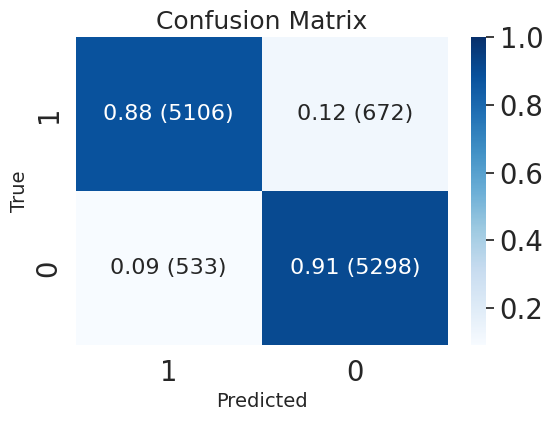

In [69]:
plot_conf_mat(confusion_matrix_raw, confusion_matrix_norm, labels)

# Computational Cost Analysis

Load Model

In [101]:
SMDisAgg_Network = UNet(signal_length, model_depth, num_channel, model_width, kernel_size, problem_type=problem_type, output_nums=output_nums, 
                      ds=D_S, ae=A_E, ag=A_G, t=t, is_transconv=is_transconv, q=q).UNet3P()
if D_S == 0:
    SMDisAgg_Network.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=tf.keras.metrics.MeanSquaredError())
elif D_S == 1:
    SMDisAgg_Network.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=tf.keras.metrics.MeanSquaredError(), loss_weights= loss_weights)

In [64]:
# Load Model and Predict
save_directory = f'trained_models/{model_name}/'+model_name+'_'+str(signal_length)+'_'+str(model_width)+'_'+str(num_channel)+'_'+str(D_S)+'.h5'
SMDisAgg_Network.load_weights(save_directory)

In [95]:
import time
# Load Test Set
Test_Data = torch.load('Test_Set.pt')
X_Test = Test_Data['X']
Y_Test = Test_Data['Y']
print(X_Test.shape)
# X_Test = X_Test[0:1,:,:]
# Predict
start_time= time.time() # set the time at which inference started
for i in range (0,39):
    Y_Pred = SMDisAgg_Network.predict(X_Test[i:i+1,:,:], verbose=0)    
stop_time = time.time()
duration = stop_time - start_time
hours = (duration//3600)/39
minutes = (duration - (hours * 3600)) // 60
seconds = duration - ((hours * 3600) + (minutes * 60))

msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
print (msg, flush=True) # print out inferenceduration time

(39, 21600, 3)
training elapsed time was 0.0 hours,  0.0 minutes, 2.64 seconds)


In [102]:
import numpy as np

trainable_params = np.sum([np.prod(v.get_shape()) for v in SMDisAgg_Network.trainable_weights])
non_trainable_params = np.sum([np.prod(v.get_shape()) for v in SMDisAgg_Network.non_trainable_weights])
total_params = trainable_params + non_trainable_params
    
print(trainable_params)
print(non_trainable_params)
print(total_params)

1852854
5952
1858806


In [103]:
SMDisAgg_Network.save('my_model.keras')

# Infinite Loop to Keep the Tab Alive

In [ ]:
while True:
    pass